In [332]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px


# Para el modelado de los datos
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Importar nuestro archivo de soporte
# -----------------------------------------------------------------------
import sys
sys.path.append('..') #pongo los 2 puntos para que salga de la carpeta
from src import soporte_clustering as sc
from src import funciones as f
from src import soporte_prep as spp
from src import soporte_encoding as se
# Para visualizar los dendrogramas
# -----------------------------------------------------------------------
import scipy.cluster.hierarchy as sch
# Configuración warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
import math

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [333]:
df = pd.read_csv('../Datos/Global_Superstore.csv', encoding='latin')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,"10,024.00",US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,"2,309.65",7,0.00,762.18,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","3,709.39",9,0.10,-288.76,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID","5,175.17",9,0.10,919.97,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless","2,892.51",5,0.10,-96.54,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed","2,832.96",8,0.00,311.52,903.04,Critical


In [334]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')


In [335]:
df['Order Date'].describe()

count                            51290
mean     2013-05-11 21:26:49.155781120
min                2011-01-01 00:00:00
25%                2012-06-19 00:00:00
50%                2013-07-08 00:00:00
75%                2014-05-22 00:00:00
max                2014-12-31 00:00:00
Name: Order Date, dtype: object

In [336]:
df[df['Customer Name'] == 'Seth Vernon'].head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
1273,37396,CA-2014-100111,2014-09-21,27-09-2014,Standard Class,SV-20365,Seth Vernon,Consumer,New York City,New York,United States,"10,035.00",US,East,FUR-CH-10004086,Furniture,Chairs,Hon 4070 Series Pagoda Armless Upholstered Sta...,"2,888.13",11,0.10,609.72,177.06,Medium
1303,37398,CA-2014-100111,2014-09-21,27-09-2014,Standard Class,SV-20365,Seth Vernon,Consumer,New York City,New York,United States,"10,035.00",US,East,FUR-CH-10001215,Furniture,Chairs,Global Troy Executive Leather Low-Back Tilter,"2,254.41",5,0.10,375.74,175.20,Medium
2134,36372,CA-2011-134572,2011-04-20,22-04-2011,Second Class,SV-20365,Seth Vernon,Consumer,Houston,Texas,United States,"77,070.00",US,Central,FUR-TA-10001705,Furniture,Tables,Bush Advantage Collection Round Conference Table,744.10,5,0.30,-95.67,128.29,High
2271,39666,CA-2013-118745,2013-06-12,17-06-2013,Standard Class,SV-20365,Seth Vernon,Consumer,Los Angeles,California,United States,"90,049.00",US,West,FUR-TA-10003473,Furniture,Tables,Bretford Rectangular Conference Table Tops,902.71,3,0.20,33.85,123.06,High
3391,17235,ES-2014-2606695,2014-07-03,03-07-2014,Same Day,SV-20365,Seth Vernon,Consumer,Middlesbrough,England,United Kingdom,NaN,EU,North,TEC-PH-10002255,Technology,Phones,"Apple Audio Dock, Full Size",672.72,4,0.00,60.48,90.65,High


In [337]:
df[df['Customer Name'] == 'Seth Vernon']['Order Priority'].value_counts()

Order Priority
Medium      55
High        22
Critical     7
Low          1
Name: count, dtype: int64

A través de algunos filtros, pude darme cuenta de que tenía desglosados los pedidos individuales de cada persona. Esto es la vez corresponde a pedidos que se asignan a una factura en particular, por lo que es posible encontrarse con la misma persona varias veces pero donde hace pedidos de una cantidad de artículos en particular, que estos pueden unirse a otros y que además se acumulan a las distintas facturas de una persona. Como lo muestro arriba y abajo de este comentario.

In [338]:
df[df['Customer Name'] == 'Seth Vernon']['Order ID'].unique()

array(['CA-2014-100111', 'CA-2011-134572', 'CA-2013-118745',
       'ES-2014-2606695', 'IN-2012-63080', 'SA-2012-4180',
       'CA-2012-168746', 'US-2012-100930', 'IN-2014-70507',
       'ES-2013-2023938', 'CA-2012-8480', 'IN-2013-77528',
       'US-2012-139843', 'ID-2011-36333', 'ID-2014-20058',
       'MX-2011-156349', 'CA-2014-159793', 'US-2014-165358',
       'US-2012-116288', 'ES-2011-3856710', 'CA-2014-161200',
       'ID-2011-29368', 'MX-2012-130603', 'US-2013-136581',
       'ID-2013-12442', 'IS-2014-7950', 'MX-2013-108133',
       'CA-2013-157511', 'ID-2012-53749', 'IN-2014-26106',
       'CA-2011-130092', 'HU-2012-9490', 'TU-2013-3390', 'ID-2013-33197',
       'MX-2014-122567', 'IN-2012-78984'], dtype=object)

In [339]:
df[df['Customer Name'] == 'Marc Crier']['Sub-Category'].unique()

array(['Phones', 'Appliances', 'Chairs', 'Copiers', 'Storage', 'Art',
       'Machines', 'Bookcases', 'Accessories', 'Binders', 'Supplies',
       'Envelopes', 'Labels', 'Furnishings', 'Fasteners', 'Paper',
       'Tables'], dtype=object)

In [340]:
preprocesar = sc.Exploracion(df)
preprocesar.explorar_datos()

5 registros aleatorios:


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
24209,4637,US-2011-102876,2011-11-19,19-11-2011,Same Day,SP-20620,Stefania Perrino,Corporate,Trujillo,La Libertad,Peru,NaN,LATAM,South,OFF-SU-10004643,Office Supplies,Supplies,"Elite Trimmer, Easy Grip",51.95,3,0.40,-13.03,8.75,High
24688,2624,MX-2013-136931,2013-08-23,28-08-2013,Standard Class,AG-10300,Aleksandra Gannaway,Corporate,Santo Domingo,Santo Domingo,Dominican Republic,NaN,LATAM,Caribbean,FUR-CH-10004194,Furniture,Chairs,"Harbour Creations Steel Folding Chair, Set of Two",160.22,3,0.20,54.02,8.42,Medium
15428,2806,US-2012-116981,2012-06-24,01-07-2012,Standard Class,MP-17470,Mark Packer,Home Office,La Romana,La Romana,Dominican Republic,NaN,LATAM,Caribbean,FUR-CH-10001455,Furniture,Chairs,"Office Star Swivel Stool, Adjustable",188.19,2,0.20,2.35,18.95,Low
23535,16575,IT-2013-1376966,2013-08-14,18-08-2013,Standard Class,AS-10240,Alan Shonely,Consumer,Venice,Veneto,Italy,NaN,EU,South,OFF-ST-10002271,Office Supplies,Storage,"Rogers Shelving, Wire Frame",110.16,3,0.40,-16.56,9.26,Medium
37171,25738,IN-2011-58341,2011-02-21,25-02-2011,Second Class,AR-10510,Andrew Roberts,Consumer,Kowloon,Hong Kong,Hong Kong,NaN,APAC,North Asia,OFF-FA-10001309,Office Supplies,Fasteners,"Stockwell Thumb Tacks, 12 Pack",25.14,2,0.00,4.74,2.96,Medium




Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  object        
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Postal Code     9994 non-null   float64       
 12  Market          51290 non-null  object        
 13  Region          51290 non-null  object        
 14  Product ID      5

,count,mean,min,25%,50%,75%,max,std
Row ID,"51,290.00","25,645.50",1.00,"12,823.25","25,645.50","38,467.75","51,290.00","14,806.29"
Order Date,51290,2013-05-11 21:26:49.155781120,2011-01-01 00:00:00,2012-06-19 00:00:00,2013-07-08 00:00:00,2014-05-22 00:00:00,2014-12-31 00:00:00,NaN
Postal Code,"9,994.00","55,190.38","1,040.00","23,223.00","56,430.50","90,008.00","99,301.00","32,063.69"
Sales,"51,290.00",246.49,0.44,30.76,85.05,251.05,"22,638.48",487.57
Quantity,"51,290.00",3.48,1.00,2.00,3.00,5.00,14.00,2.28
Discount,"51,290.00",0.14,0.00,0.00,0.00,0.20,0.85,0.21
Profit,"51,290.00",28.61,"-6,599.98",0.00,9.24,36.81,"8,399.98",174.34
Shipping Cost,"51,290.00",26.38,0.00,2.61,7.79,24.45,933.57,57.30




Estadísticas descriptivas de las columnas categóricas:


,count,unique,top,freq
Order ID,51290,25035,CA-2014-100111,14
Ship Date,51290,1464,22-11-2014,130
Ship Mode,51290,4,Standard Class,30775
Customer ID,51290,1590,PO-18850,97
Customer Name,51290,795,Muhammed Yedwab,108
Segment,51290,3,Consumer,26518
City,51290,3636,New York City,915
State,51290,1094,California,2001
Country,51290,147,United States,9994
Market,51290,7,APAC,11002




Número de valores nulos por columna:
Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64


Distribución de valores categóricos:

Columna: Order ID
Order ID
CA-2014-100111    14
NI-2014-8880      13
TO-2014-9950      13
IN-2012-41261     13
IN-2013-42311     13
                  ..
ID-2014-68085      1
ID-2012-85221      1
CA-2012-119697     1
CA-2011-151967     1
MX-2012-134460     1
Name: count, Length: 25035, dtype: int64

Columna: Ship Date
Ship Date
22-

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
Row ID,1.00,0.01,-0.04,-0.17,0.09,-0.02,-0.04
Postal Code,0.01,1.00,-0.02,0.01,0.06,-0.03,-0.03
Sales,-0.04,-0.02,1.00,0.31,-0.09,0.48,0.77
Quantity,-0.17,0.01,0.31,1.00,-0.02,0.10,0.27
Discount,0.09,0.06,-0.09,-0.02,1.00,-0.32,-0.08
Profit,-0.02,-0.03,0.48,0.10,-0.32,1.00,0.35
Shipping Cost,-0.04,-0.03,0.77,0.27,-0.08,0.35,1.00


## EDA

Observaciones:
- Tenemos nulos solamente en una columna (Postal Code)
- No tenemos duplicados
- No hay muchas correlaciones evidentes entre las columnas numéricas pero sí se observa:
    ** Sales-Shipping Cost (0.76)**
    **  Profit-Sales (0.48) **
- Estamos manejando unos datos que corresponden a órdenes de pedidos desde el primer día del 2011 hasta el último día del 2014 (1 de enero a 31 de diciembre)

In [341]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country',
       'Postal Code', 'Market', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping Cost', 'Order Priority'],
      dtype='object')

In [342]:
df_copy = df.copy()

Me he cargado la columna de código postal porque es la única que tiene nulos, además de que tiene una gran cantidad de nulos. Las demás columnas tampoco son tan importantes para mi abordaje.

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  object        
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Postal Code     9994 non-null   float64       
 12  Market          51290 non-null  object        
 13  Region          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Ca

In [344]:
df.nunique()

Row ID            51290
Order ID          25035
Order Date         1430
Ship Date          1464
Ship Mode             4
Customer ID        1590
Customer Name       795
Segment               3
City               3636
State              1094
Country             147
Postal Code         631
Market                7
Region               13
Product ID        10292
Category              3
Sub-Category         17
Product Name       3788
Sales             22995
Quantity             14
Discount             27
Profit            24575
Shipping Cost     10037
Order Priority        4
dtype: int64

De la siguiente manera me di cuenta que existe un caso muy particular, una misma persona corresponde a distintos países diferentes en sus pedidos. Esto a la vez hace que corresponda a una region distinta, y un mercado distinto. Por ende decidí agrupar mis datos directamente por los clientes individuales.

In [345]:
df[df['Customer Name'] == 'Aaron Bergman']['Country'].value_counts()

Country
Australia         10
Italy              7
Germany            6
Indonesia          6
India              6
Thailand           6
United States      6
France             5
United Kingdom     4
Ukraine            4
Zambia             4
Mexico             3
Vietnam            3
Brazil             3
Iran               2
Cameroon           2
Guatemala          2
China              2
Netherlands        2
Nicaragua          2
El Salvador        2
Argentina          2
Name: count, dtype: int64

In [346]:
df.groupby('Customer Name')['Sales'].sum()

Customer Name
Aaron Bergman        24,644.63
Aaron Hawkins        20,759.51
Aaron Smayling       14,212.63
Adam Bellavance      20,186.78
Adam Hart            21,718.20
                        ...   
Xylona Preis         12,198.95
Yana Sorensen        20,032.44
Yoseph Carroll       20,164.38
Zuschuss Carroll     28,479.99
Zuschuss Donatelli   12,430.57
Name: Sales, Length: 795, dtype: float64

In [347]:
df.groupby('Customer Name')['Discount'].mean()

Customer Name
Aaron Bergman        0.11
Aaron Hawkins        0.16
Aaron Smayling       0.17
Adam Bellavance      0.13
Adam Hart            0.09
                     ... 
Xylona Preis         0.08
Yana Sorensen        0.07
Yoseph Carroll       0.07
Zuschuss Carroll     0.22
Zuschuss Donatelli   0.12
Name: Discount, Length: 795, dtype: float64

In [348]:
df.groupby("Customer Name")[["Discount","Profit"]].agg(["mean","sum"])

Discount       Profit         
                       mean   sum   mean      sum
Customer Name                                    
Aaron Bergman          0.11  9.80  52.62 4,683.21
Aaron Hawkins          0.16  9.01  43.77 2,450.93
Aaron Smayling         0.17 10.06   6.15   369.16
Adam Bellavance        0.13  8.96  73.23 4,979.98
Adam Hart              0.09  7.83  22.64 1,902.03
...                     ...   ...    ...      ...
Xylona Preis           0.08  5.17  21.39 1,304.72
Yana Sorensen          0.07  4.40  55.65 3,450.41
Yoseph Carroll         0.07  3.92  77.63 4,347.18
Zuschuss Carroll       0.22 18.81   5.14   436.94
Zuschuss Donatelli     0.12  6.25   3.74   201.74

[795 rows x 4 columns]

In [349]:
df.groupby("Customer Name")[["Discount","Sales"]].agg({"Discount":"mean","Sales":"sum"})

,Discount,Sales
Customer Name,,
Aaron Bergman,0.11,"24,644.63"
Aaron Hawkins,0.16,"20,759.51"
Aaron Smayling,0.17,"14,212.63"
Adam Bellavance,0.13,"20,186.78"
Adam Hart,0.09,"21,718.20"
...,...,...
Xylona Preis,0.08,"12,198.95"
Yana Sorensen,0.07,"20,032.44"
Yoseph Carroll,0.07,"20,164.38"


### Conociendo mis datos

# Pendiente

In [350]:
df[df['Profit'] < 0]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
1,26341,IN-2013-77878,2013-02-05,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","3,709.39",9,0.10,-288.76,923.63,Critical
3,13524,ES-2013-1579342,2013-01-28,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless","2,892.51",5,0.10,-96.54,910.16,Medium
9,40936,CA-2012-116638,2012-01-28,31-01-2012,Second Class,JH-15985,Joseph Holt,Consumer,Concord,North Carolina,United States,"28,027.00",US,South,FUR-TA-10000198,Furniture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,"4,297.64",13,0.40,"-1,862.31",865.74,Critical
30,220,US-2011-128776,2011-12-28,30-12-2011,Second Class,RR-19525,Rick Reed,Corporate,Santo Domingo,Santo Domingo,Dominican Republic,NaN,LATAM,Caribbean,TEC-PH-10002815,Technology,Phones,"Samsung Smart Phone, VoIP","1,696.64",5,0.20,-148.46,704.06,Critical
32,32735,CA-2012-139731,2012-10-15,15-10-2012,Same Day,JE-15745,Joel Eaton,Consumer,Amarillo,Texas,United States,"79,109.00",US,Central,FUR-CH-10002024,Furniture,Chairs,HON 5400 Series Task Chairs for Big and Tall,"2,453.43",5,0.30,-350.49,690.42,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51276,31558,US-2014-155299,2014-06-09,13-06-2014,Standard Class,Dl-13600,Dorris liebe,Corporate,Pasadena,Texas,United States,"77,506.00",US,Central,OFF-AP-10002203,Office Supplies,Appliances,Eureka Disposable Bags for Sanitaire Vibra Gro...,1.62,2,0.80,-4.47,0.02,Medium
51278,43818,NI-2011-4700,2011-09-08,10-09-2011,Second Class,PO-8865,Patrick O'Donnell,Consumer,Lagos,Lagos,Nigeria,NaN,Africa,Africa,OFF-STA-10001791,Office Supplies,Art,"Stanley Highlighters, Water Color",5.36,1,0.70,-6.46,0.02,High
51279,46231,ZI-2011-4350,2011-03-21,26-03-2011,Standard Class,AS-285,Alejandro Savely,Corporate,Harare,Harare,Zimbabwe,NaN,Africa,Africa,OFF-SAN-10001862,Office Supplies,Art,"Sanford Highlighters, Easy-Erase",9.61,2,0.70,-21.17,0.02,Medium
51280,46582,TU-2014-6730,2014-11-29,30-11-2014,First Class,KF-6285,Karen Ferguson,Home Office,Midyat,Mardin,Turkey,NaN,EMEA,EMEA,OFF-BOS-10000350,Office Supplies,Art,"Boston Pens, Blue",34.13,6,0.60,-49.57,0.02,Medium


In [351]:
df.groupby(['Market', 'Region'])['Region'].count()

Market  Region        
APAC    Central Asia      2048
        North Asia        2338
        Oceania           3487
        Southeast Asia    3129
Africa  Africa            4587
Canada  Canada             384
EMEA    EMEA              5029
EU      Central           5822
        North             2141
        South             2037
LATAM   Caribbean         1690
        Central           2972
        North             2644
        South             2988
US      Central           2323
        East              2848
        South             1620
        West              3203
Name: Region, dtype: int64

De esta forma puedo conocer las regiones de mis mercados, para conocer exactamente lo que se mueve allí y el contenido de este. De igual forma, poder investigar las regiones dentro de cada una y los países.

In [352]:
pd.options.display.float_format = '{:,.2f}'.format

In [353]:
df.groupby('Market')['Sales'].sum()

Market
APAC     3,585,744.13
Africa     783,773.21
Canada      66,928.17
EMEA       806,161.31
EU       2,938,089.06
LATAM    2,164,605.17
US       2,297,200.86
Name: Sales, dtype: float64

Dos cosas importantes visualizadas: profit-sales, en 0.48% Y tener sales-shipping cost

In [354]:
# df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')

# df['Discount_Category'] = pd.cut(
#     df['Discount'],
#     bins=[-float('inf'), 0.250, 0.500, 0.750, float('inf')],  # Límites de las categorías
#     labels=['< 0.250', '0.250 - 0.500', '0.500 - 0.750', '> 0.750']  # Nombres de las categorías
# )

# print(df[['Discount', 'Discount_Category']])

In [355]:
# df['Quantity_Group'] = pd.cut(
#     df['Quantity'],
#     bins=[-float('inf'), 5, 10, 15],  # Límites de los grupos
#     labels=['<= 5', '6 - 10', '11 - 15']  # Nombres de los grupos
# )

# # Ver los resultados
# print(df[['Quantity', 'Quantity_Group']].head())


Convierto a categóricas las columnas de Quantity para hacer más fácil la categorización de las mismas.

In [356]:
# df.drop(columns=['Discount', 'Quantity'], inplace=True)

Los descuentos se agrupan por debajo del 25% cerca del 80% de los pedidos.

La cantidad de artículos, se agrupan en un 83% para menos de 5 artículos.

In [357]:
df_copy.drop(columns=['Postal Code', 'Row ID', 'Product ID', 'Customer ID', 'Ship Date', 'City', 'State', 'Product Name', 'Order ID', 'Order Date'], inplace=True)

In [358]:
df_copy.head()

,Ship Mode,Customer Name,Segment,Country,Market,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,Same Day,Rick Hansen,Consumer,United States,US,East,Technology,Accessories,"2,309.65",7,0.00,762.18,933.57,Critical
1,Second Class,Justin Ritter,Corporate,Australia,APAC,Oceania,Furniture,Chairs,"3,709.39",9,0.10,-288.76,923.63,Critical
2,First Class,Craig Reiter,Consumer,Australia,APAC,Oceania,Technology,Phones,"5,175.17",9,0.10,919.97,915.49,Medium
3,First Class,Katherine Murray,Home Office,Germany,EU,Central,Technology,Phones,"2,892.51",5,0.10,-96.54,910.16,Medium
4,Same Day,Rick Hansen,Consumer,Senegal,Africa,Africa,Technology,Copiers,"2,832.96",8,0.00,311.52,903.04,Critical


In [359]:
df_copy.describe()

,Sales,Quantity,Discount,Profit,Shipping Cost
count,"51,290.00","51,290.00","51,290.00","51,290.00","51,290.00"
mean,246.49,3.48,0.14,28.61,26.38
std,487.57,2.28,0.21,174.34,57.30
min,0.44,1.00,0.00,"-6,599.98",0.00
25%,30.76,2.00,0.00,0.00,2.61
50%,85.05,3.00,0.00,9.24,7.79
75%,251.05,5.00,0.20,36.81,24.45
max,"22,638.48",14.00,0.85,"8,399.98",933.57


In [360]:
preprocesar_cluster = sc.Exploracion(df_copy)

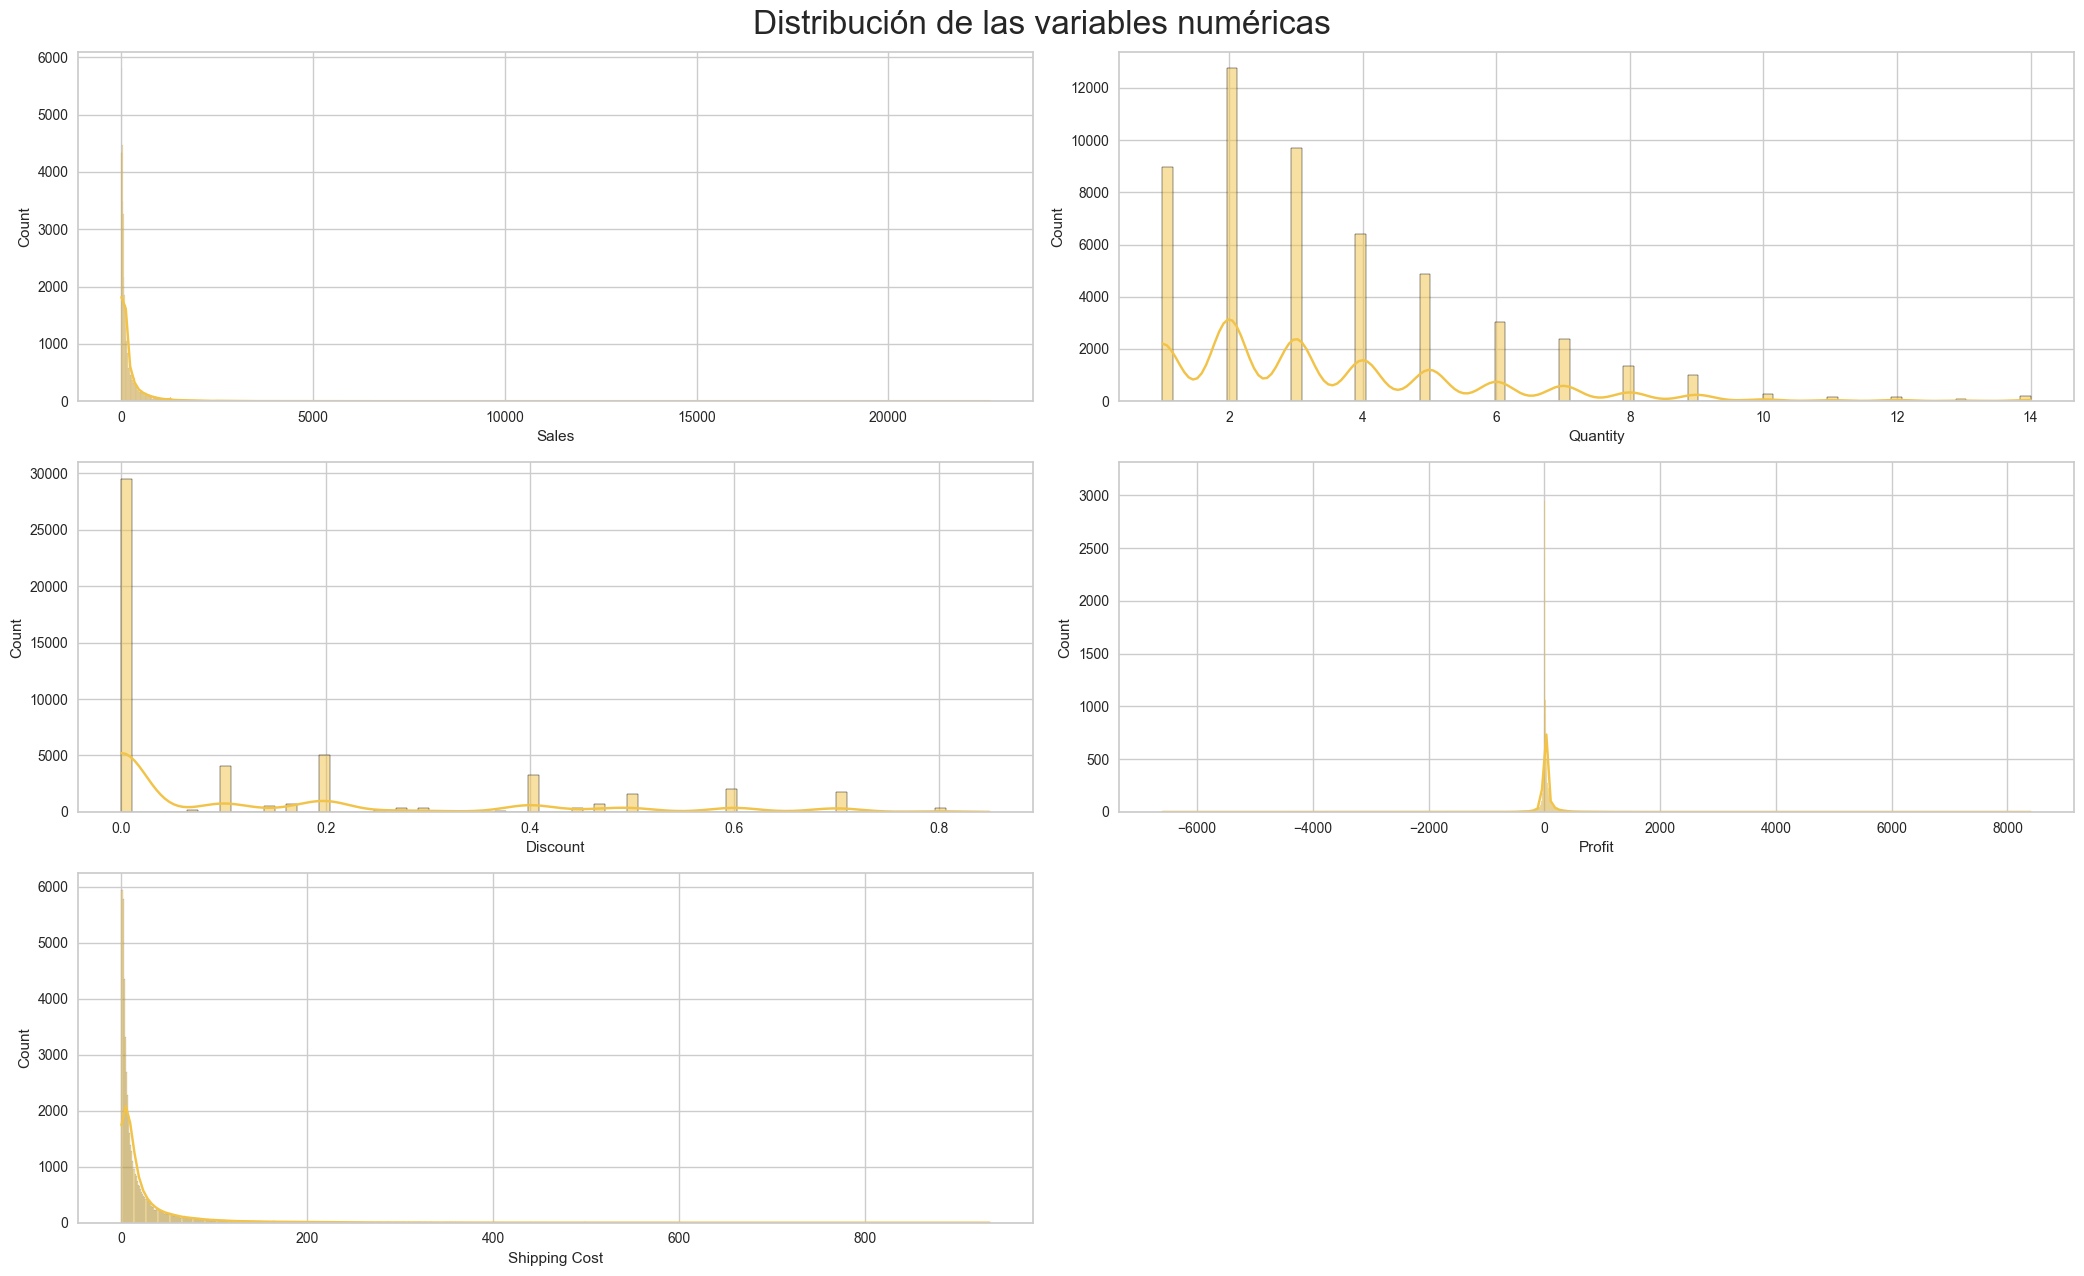

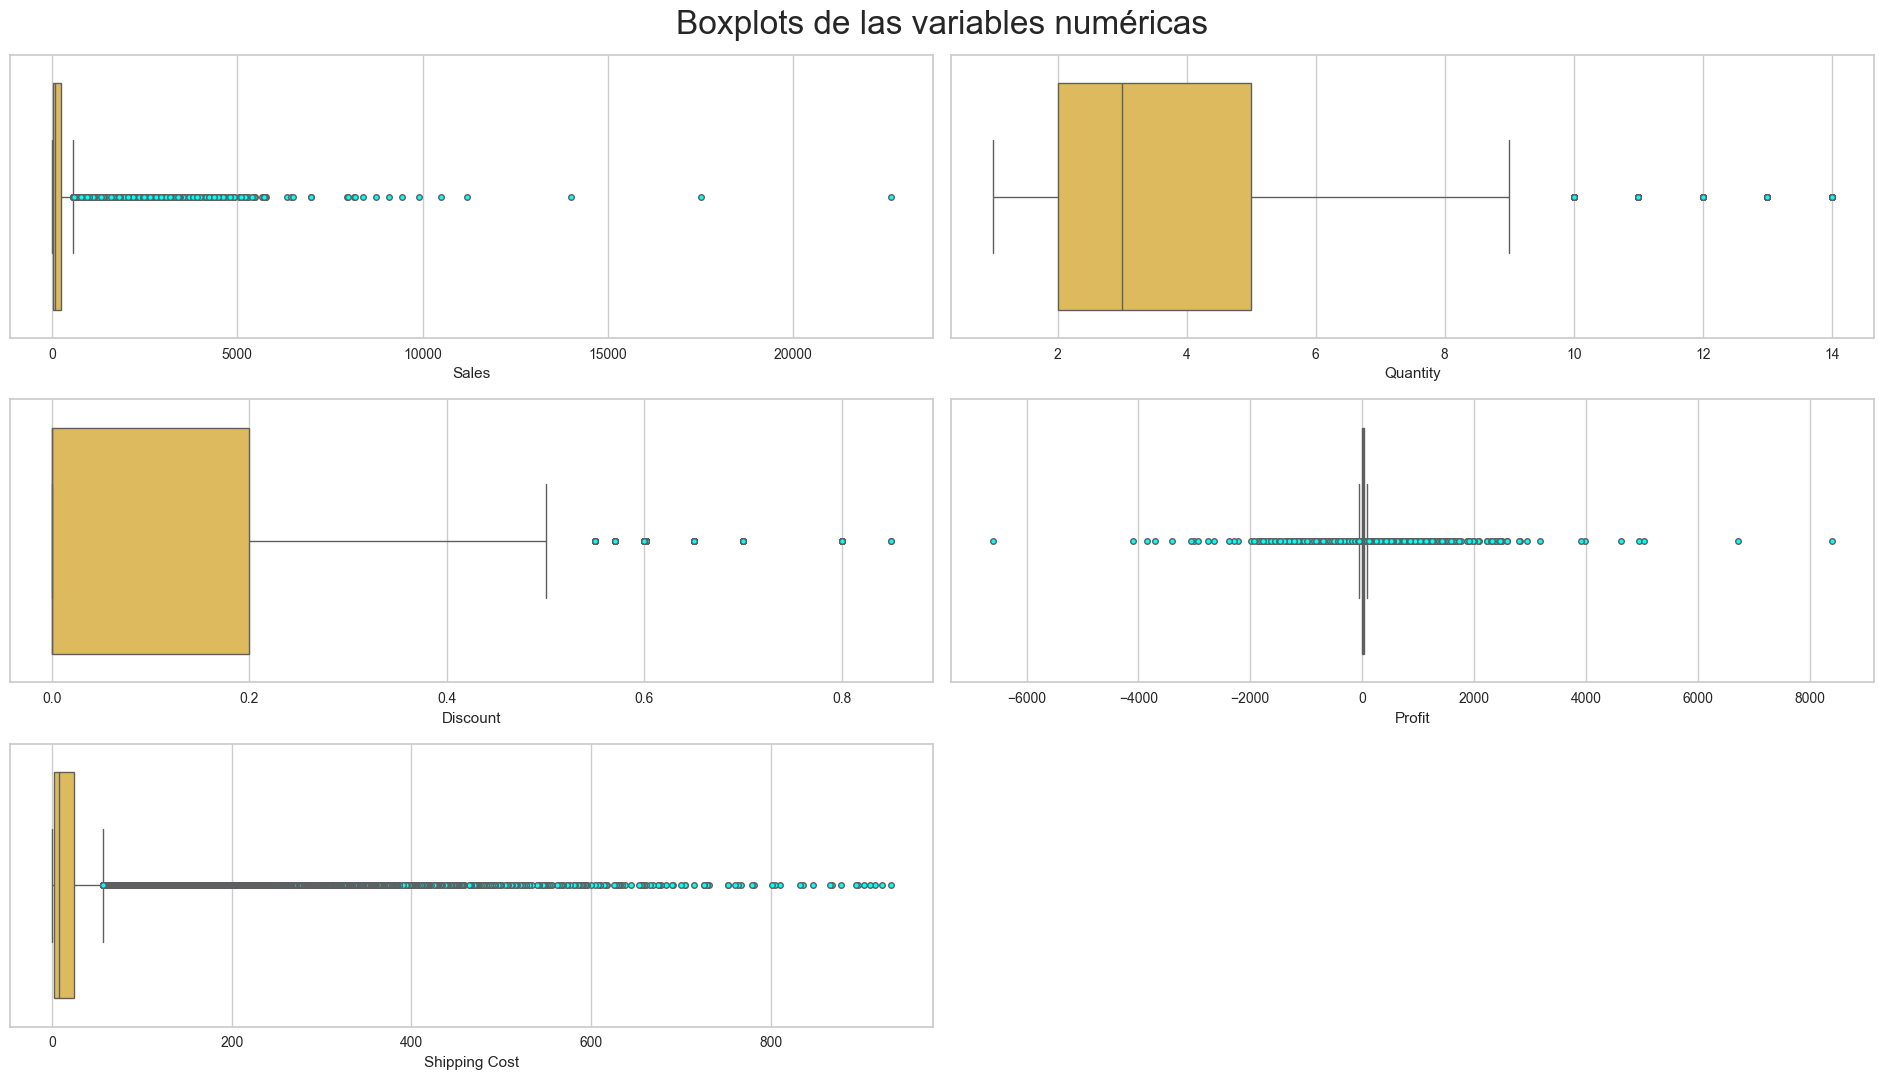

In [361]:
preprocesar_cluster.visualizar_numericas()

Para nuestras variables numéricas, tenemos muy poca distribución en Sales and Profit. Esto significa que la mayor cantidad se concentra en un intervalo muy específico (algo que podemos observar dentro de los boxplots). Tiene sentido ya que recordemos que cada fila representa un pedido específico que pertene a una factura en particular. Al ver el desglose de esta forma, es probable que no se entienda tan bien como se vería si desglosamos la factura como un conjunto.
- Vemos que las cantidades de los pedidos se concentra entre 2-4 artículos, luego hay menos frecuencia.
- El descuento como tal es normalmente cero, sin embargo podemos llegar a encontrar casos muy particulares que se elevan a un 80% de descuento.
- Shipping Cost tiene un comportamiento similar a Sales and Profit. Tiene una alta concentración en un rango muy específico.

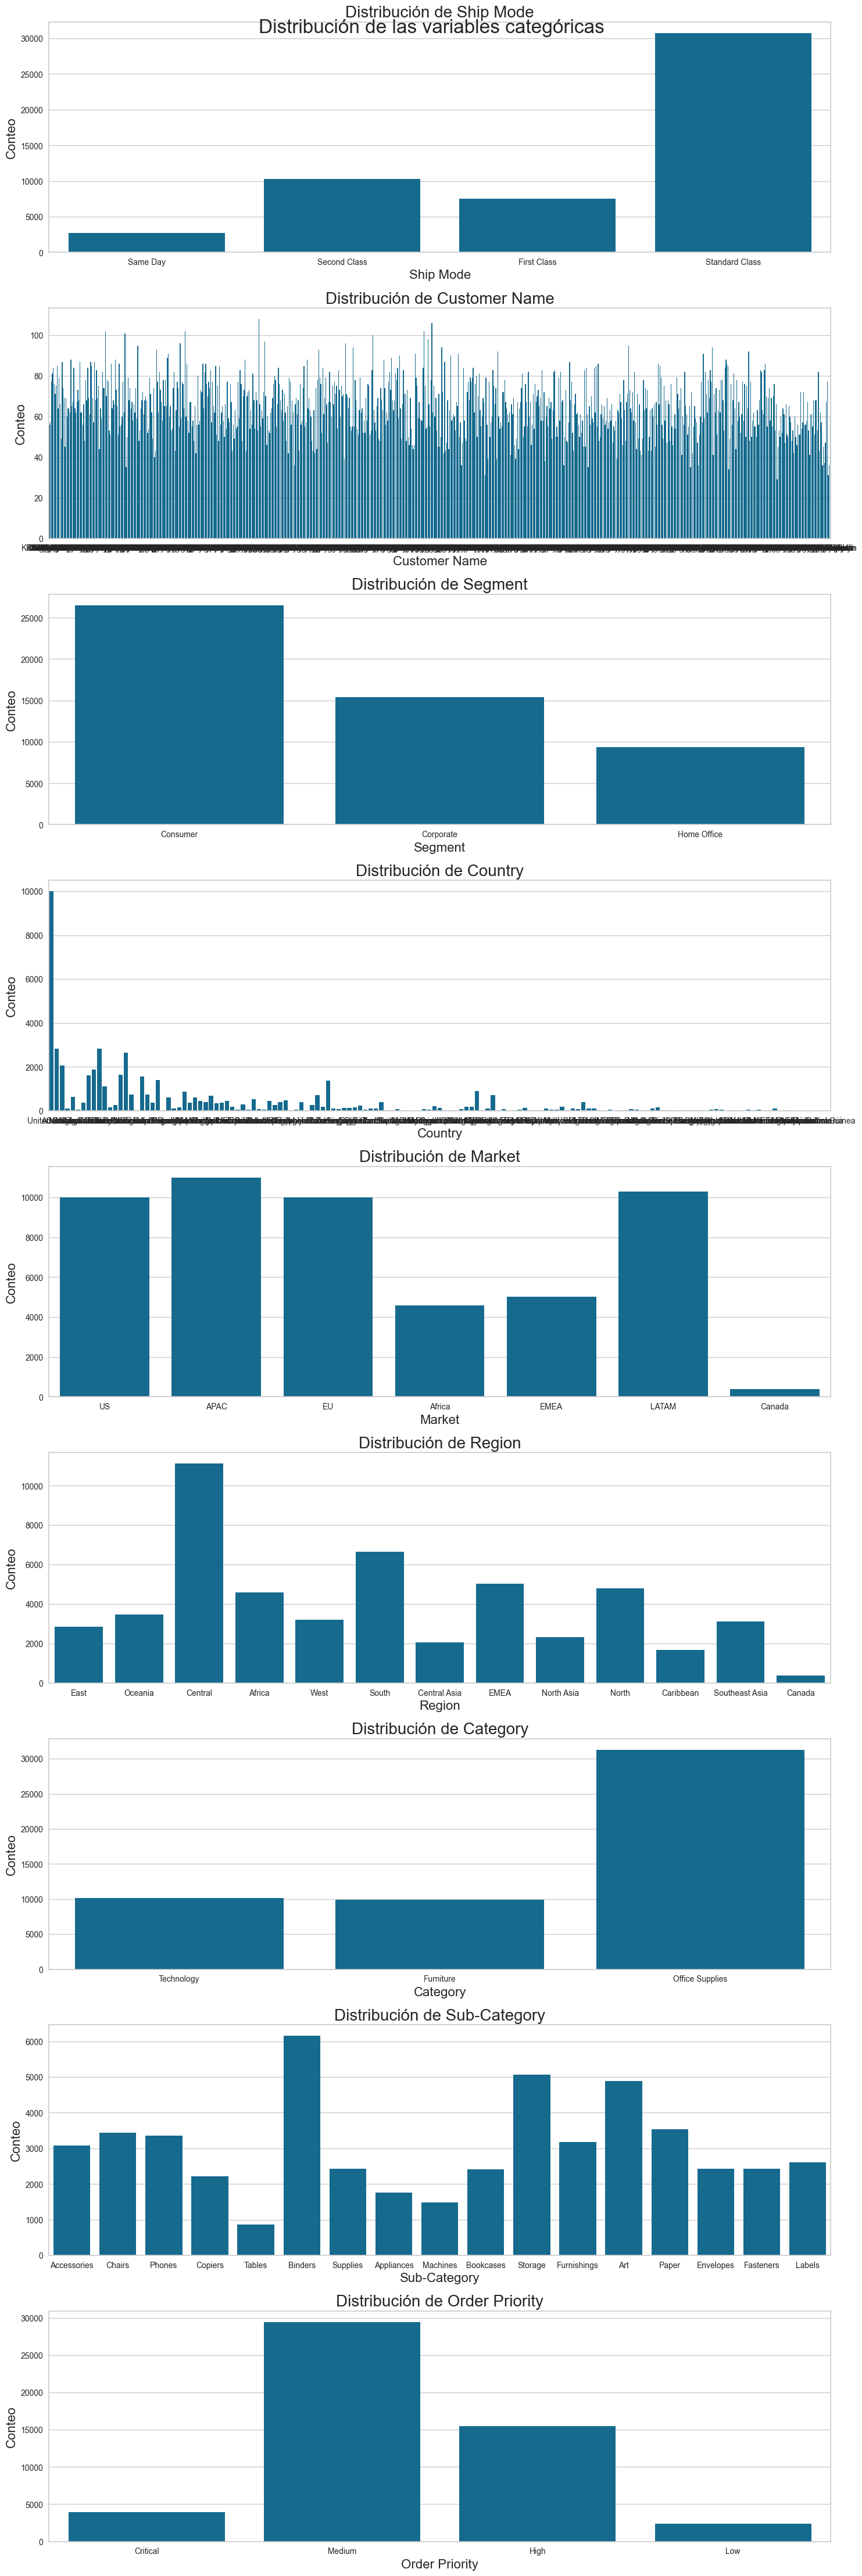

In [362]:
preprocesar_cluster.visualizar_categoricas()

Para las categóricas:
- Ship Mode tiene el Standard Class como el más dominante, con creces.
- En cuanto a segmento, el que más predomina es el Consumer, seguido de Corporate and Home Office.
- En relación a los mercados y regiones, no es muy confiable determinar cuál es el más importante ya que, como comprobé, muchos de los pedidos de una misma persona podían estar correspondidos a distintos mercados, paises y regiones. Lo cual no hace mucho sentido para diferenciar.
- En cuanto a categoría de los pedidos, hay un claro ganador en Office Supplies.
- En subcategoría tenemos un triungo por parte de Binders, o carpetas para archivar.

## Data frame a clustorizar

In [363]:
df_clustorizar = df.groupby("Customer Name")[["Order ID","Discount","Sales", 'Profit', 'Shipping Cost']].agg(facturas_total=('Order ID', 'count'), descuento_medio=("Discount","mean"),compras_total=("Sales","sum"),compras_media=("Sales","mean"),beneficio_total=('Profit', 'sum'), costo_envio_medio=('Shipping Cost', 'mean'))

In [365]:
df_clustorizar.describe()

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio
count,795.00,795.00,795.00,795.00,795.00,795.00
mean,64.52,0.14,"15,902.52",246.23,"1,845.86",26.35
std,13.43,0.05,"5,209.81",61.77,"1,544.34",7.44
min,29.00,0.05,"3,892.23",108.12,"-6,151.56",9.22
25%,55.00,0.11,"12,242.61",205.58,984.34,21.19
50%,64.00,0.14,"15,257.53",239.77,"1,788.72",25.27
75%,74.00,0.17,"18,770.80",278.52,"2,603.60",30.49
max,108.00,0.30,"40,488.07",703.42,"8,672.90",58.22


Podemos observar una mediana ligeramente inferior o igual a la media de nuestras columnas.

In [366]:
visuales = spp.Visualizador(df_clustorizar)

In [367]:
df_clustorizar.head()

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio
Customer Name,,,,,,
Aaron Bergman,89,0.11,"24,644.63",276.91,"4,683.21",35.15
Aaron Hawkins,56,0.16,"20,759.51",370.71,"2,450.93",40.88
Aaron Smayling,60,0.17,"14,212.63",236.88,369.16,22.88
Adam Bellavance,68,0.13,"20,186.78",296.86,"4,979.98",40.17
Adam Hart,84,0.09,"21,718.20",258.55,"1,902.03",28.17


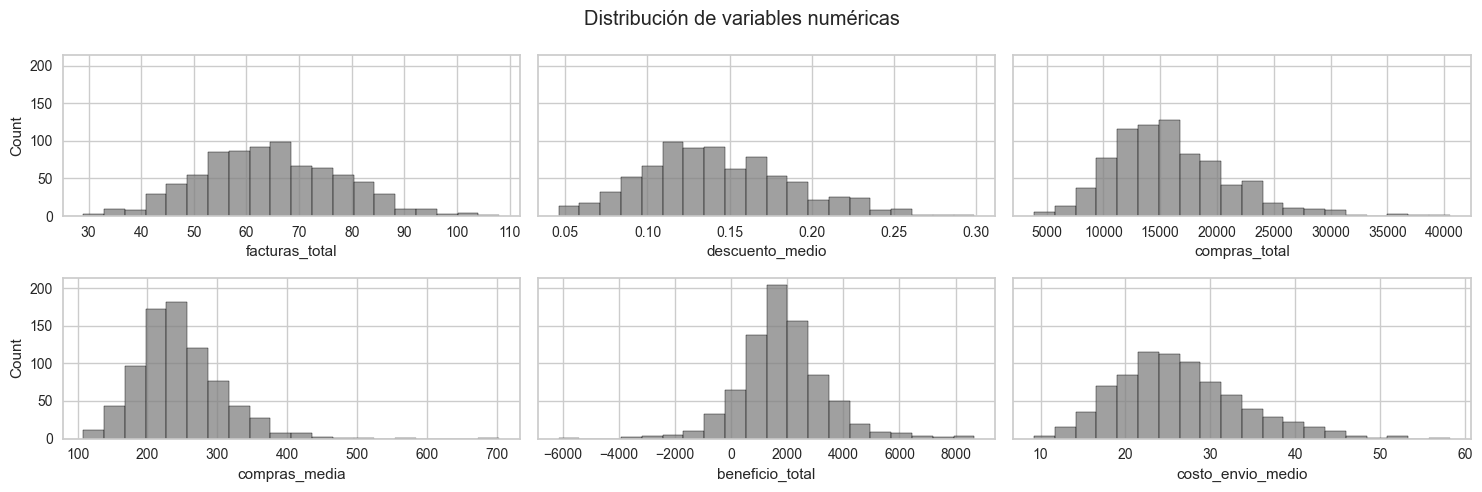

In [368]:
visuales.plot_numericas()

## Escalar numéricas

In [369]:
df_clean = df_clustorizar.copy()

In [370]:
df_copia_cluster = df_clustorizar.copy()

In [371]:
df_copia_cluster.head()

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio
Customer Name,,,,,,
Aaron Bergman,89,0.11,"24,644.63",276.91,"4,683.21",35.15
Aaron Hawkins,56,0.16,"20,759.51",370.71,"2,450.93",40.88
Aaron Smayling,60,0.17,"14,212.63",236.88,369.16,22.88
Adam Bellavance,68,0.13,"20,186.78",296.86,"4,979.98",40.17
Adam Hart,84,0.09,"21,718.20",258.55,"1,902.03",28.17


In [372]:
lista_col_num = df_clustorizar.select_dtypes(include=[int, float]).columns.tolist()

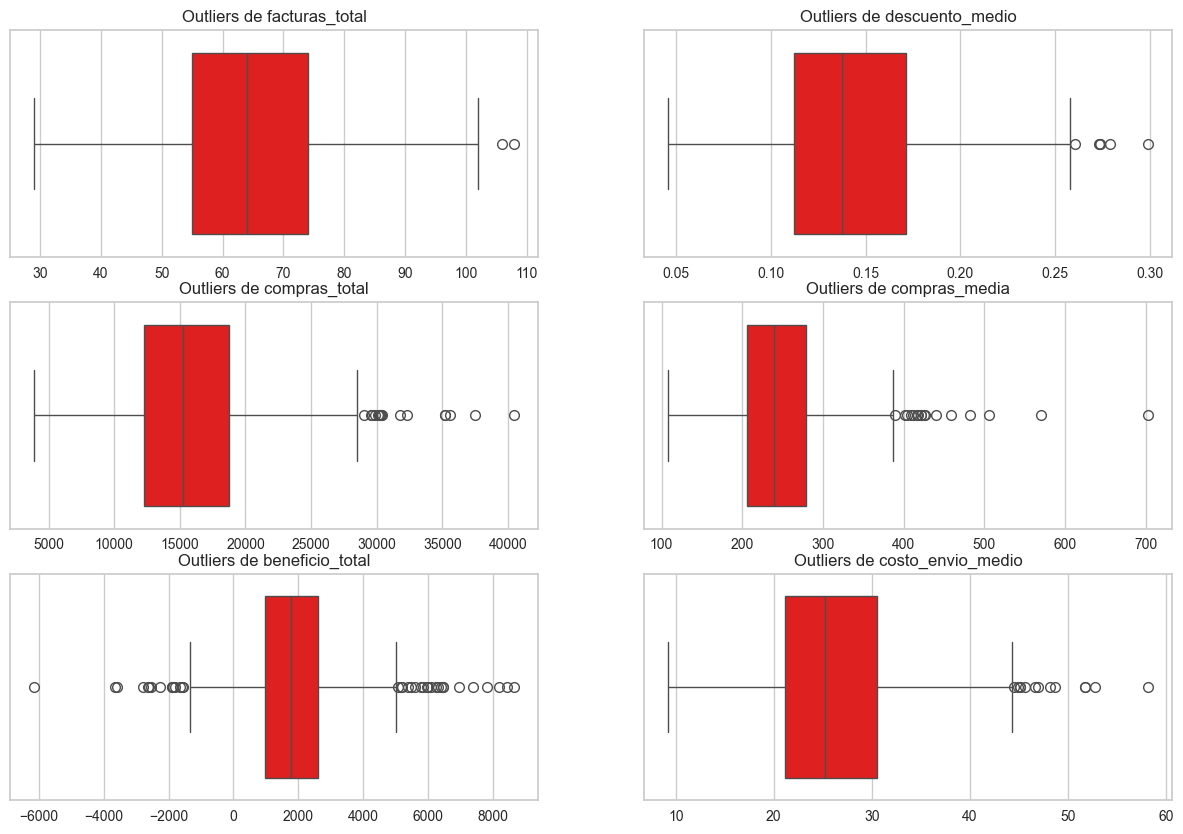

In [373]:
f.detectar_outliers(df_clustorizar)

In [374]:
f.escalar_columnas(df_copia_cluster, lista_col_num)

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio,facturas_total_robust,descuento_medio_robust,compras_total_robust,compras_media_robust,beneficio_total_robust,costo_envio_medio_robust,facturas_total_minmax,descuento_medio_minmax,compras_total_minmax,compras_media_minmax,beneficio_total_minmax,costo_envio_medio_minmax,facturas_total_norm,descuento_medio_norm,compras_total_norm,compras_media_norm,beneficio_total_norm,costo_envio_medio_norm,facturas_total_stand,descuento_medio_stand,compras_total_stand,compras_media_stand,beneficio_total_stand,costo_envio_medio_stand
Customer Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron Bergman,89,0.11,"24,644.63",276.91,"4,683.21",35.15,1.32,-0.47,1.44,0.51,1.79,1.06,0.76,0.25,0.57,0.28,0.73,0.53,0.00,0.00,0.98,0.01,0.19,0.00,1.82,-0.73,1.68,0.50,1.84,1.18
Aaron Hawkins,56,0.16,"20,759.51",370.71,"2,450.93",40.88,-0.42,0.40,0.84,1.80,0.41,1.68,0.34,0.45,0.46,0.44,0.58,0.65,0.00,0.00,0.99,0.02,0.12,0.00,-0.63,0.40,0.93,2.02,0.39,1.95
Aaron Smayling,60,0.17,"14,212.63",236.88,369.16,22.88,-0.21,0.51,-0.16,-0.04,-0.88,-0.26,0.39,0.48,0.28,0.22,0.44,0.28,0.00,0.00,1.00,0.02,0.03,0.00,-0.34,0.55,-0.32,-0.15,-0.96,-0.47
Adam Bellavance,68,0.13,"20,186.78",296.86,"4,979.98",40.17,0.21,-0.10,0.76,0.78,1.97,1.60,0.49,0.34,0.45,0.32,0.75,0.63,0.00,0.00,0.97,0.01,0.24,0.00,0.26,-0.25,0.82,0.82,2.03,1.86
Adam Hart,84,0.09,"21,718.20",258.55,"1,902.03",28.17,1.05,-0.75,0.99,0.26,0.07,0.31,0.70,0.19,0.49,0.25,0.54,0.39,0.00,0.00,1.00,0.01,0.09,0.00,1.45,-1.10,1.12,0.20,0.04,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xylona Preis,61,0.08,"12,198.95",199.98,"1,304.72",17.62,-0.16,-0.90,-0.47,-0.55,-0.30,-0.82,0.41,0.15,0.23,0.15,0.50,0.17,0.00,0.00,0.99,0.02,0.11,0.00,-0.26,-1.29,-0.71,-0.75,-0.35,-1.17
Yana Sorensen,62,0.07,"20,032.44",323.10,"3,450.41",27.83,-0.11,-1.13,0.73,1.14,1.03,0.27,0.42,0.10,0.44,0.36,0.65,0.38,0.00,0.00,0.99,0.02,0.17,0.00,-0.19,-1.60,0.79,1.25,1.04,0.20
Yoseph Carroll,56,0.07,"20,164.38",360.08,"4,347.18",41.81,-0.42,-1.15,0.75,1.65,1.58,1.78,0.34,0.10,0.44,0.42,0.71,0.67,0.00,0.00,0.98,0.02,0.21,0.00,-0.63,-1.62,0.82,1.84,1.62,2.08


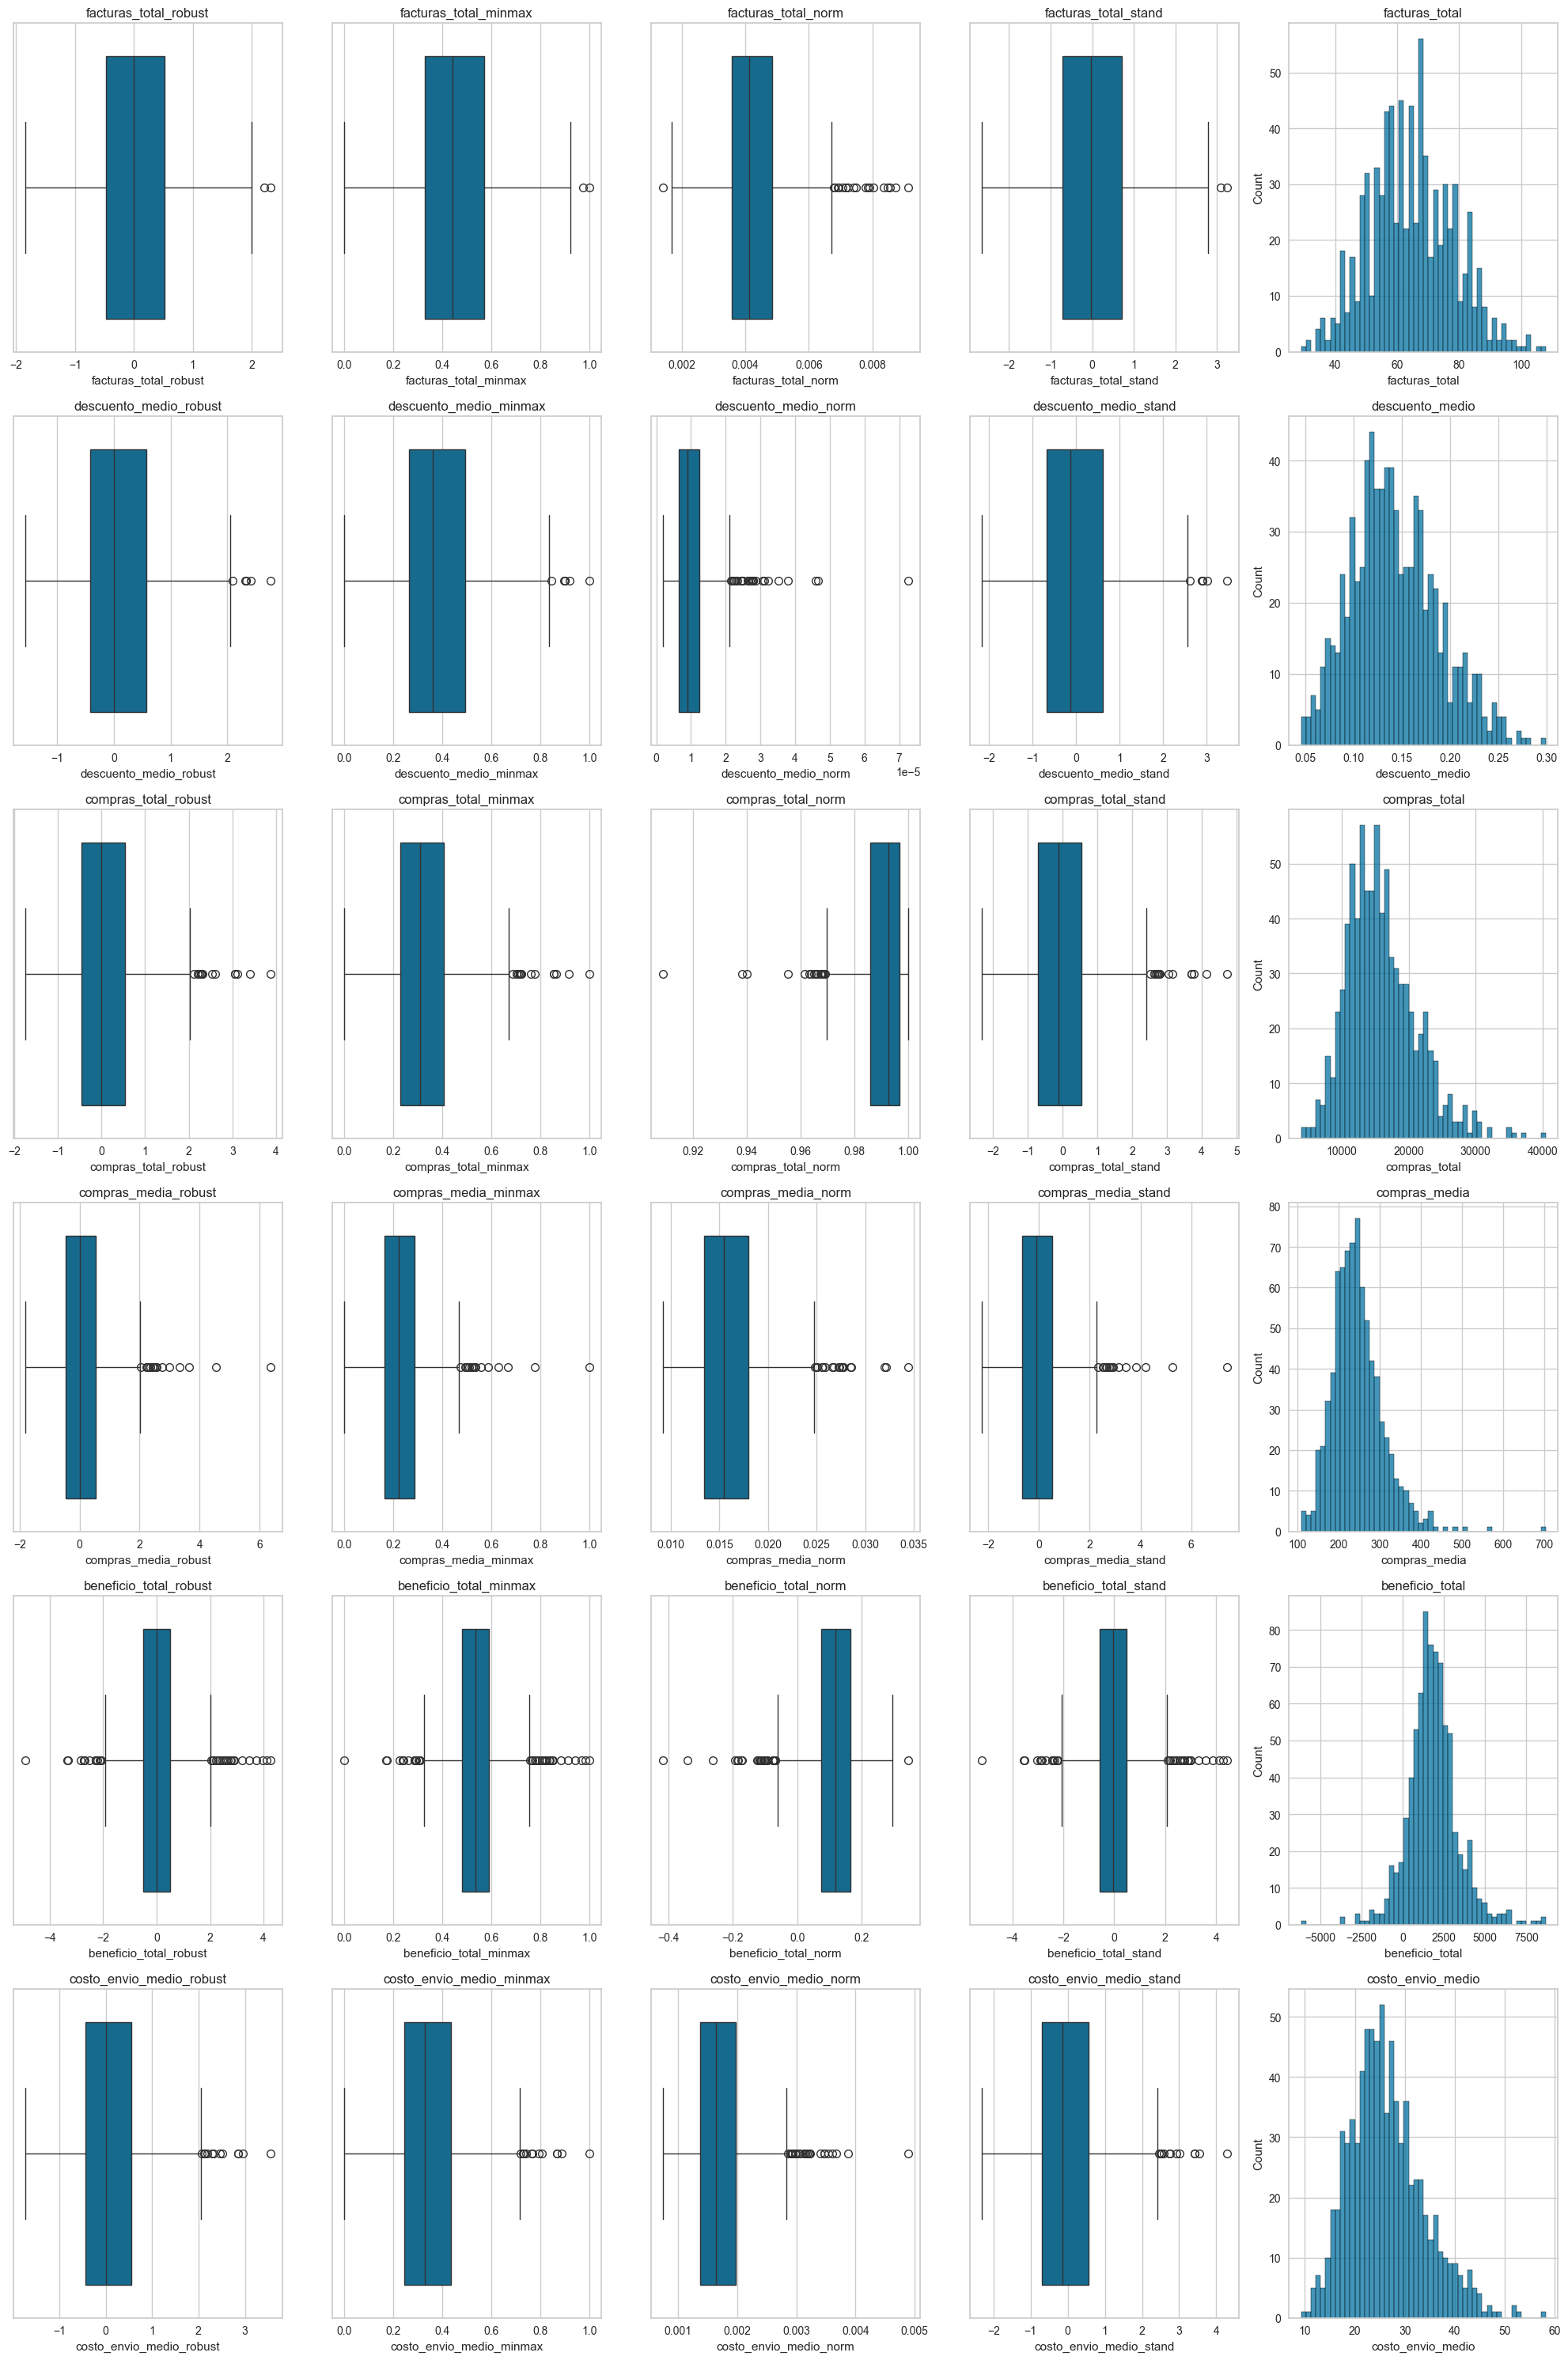

In [375]:
f.visualizar_escalados_completos(df_copia_cluster, lista_col_num)

Por lo visto, tengo muchos outliers por lo que decido continuar con el modelo Robust.

In [376]:
f.escalar_columnas_metodo(df_clustorizar, lista_col_num, 'robust')

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio
Customer Name,,,,,,
Aaron Bergman,1.32,-0.47,1.44,0.51,1.79,1.06
Aaron Hawkins,-0.42,0.40,0.84,1.80,0.41,1.68
Aaron Smayling,-0.21,0.51,-0.16,-0.04,-0.88,-0.26
Adam Bellavance,0.21,-0.10,0.76,0.78,1.97,1.60
Adam Hart,1.05,-0.75,0.99,0.26,0.07,0.31
...,...,...,...,...,...,...
Xylona Preis,-0.16,-0.90,-0.47,-0.55,-0.30,-0.82
Yana Sorensen,-0.11,-1.13,0.73,1.14,1.03,0.27
Yoseph Carroll,-0.42,-1.15,0.75,1.65,1.58,1.78


# Clustorizar

In [377]:
df_modelo = df_clustorizar.copy()

In [378]:
df_modelo.head()

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio
Customer Name,,,,,,
Aaron Bergman,1.32,-0.47,1.44,0.51,1.79,1.06
Aaron Hawkins,-0.42,0.40,0.84,1.80,0.41,1.68
Aaron Smayling,-0.21,0.51,-0.16,-0.04,-0.88,-0.26
Adam Bellavance,0.21,-0.10,0.76,0.78,1.97,1.60
Adam Hart,1.05,-0.75,0.99,0.26,0.07,0.31


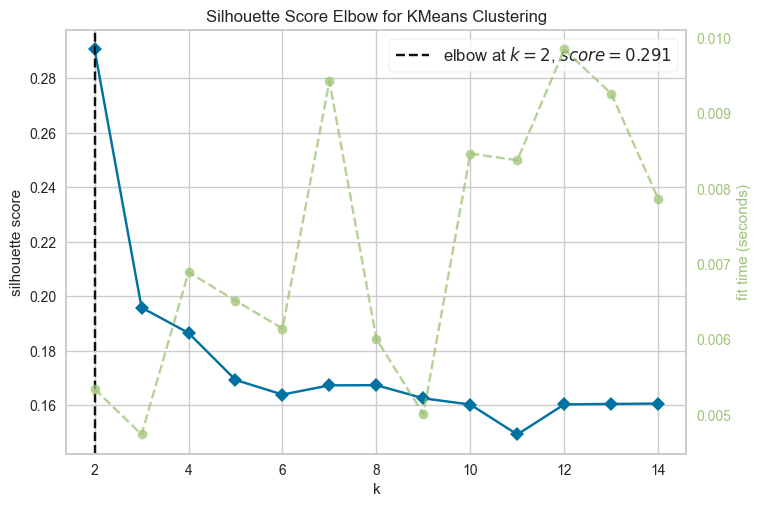

In [379]:
# instanciamos la clase de clustering
modelos = sc.Clustering(df_modelo)

# sacamos el número de clusters óptimos para hacer el Kmeans 
modelos.sacar_clusters_kmeans()

Utilizando el método de K_means, nos arroja un silhouette de 0.291, y un k=2. No es una metrica muy alta pero al explorar los datos buscaré si estos tienen una explicación lógica que me pueda dar indicios.

## Modelo K Means

In [380]:
# aplicamos el modelo de Kmeans al dataframe 
df_modelo, labels  = modelos.modelo_kmeans(df_modelo, 2)

# mostramos el DataFrame
df_modelo.head()


,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio,clusters_kmeans
Customer Name,,,,,,,
Aaron Bergman,1.32,-0.47,1.44,0.51,1.79,1.06,0
Aaron Hawkins,-0.42,0.40,0.84,1.80,0.41,1.68,0
Aaron Smayling,-0.21,0.51,-0.16,-0.04,-0.88,-0.26,1
Adam Bellavance,0.21,-0.10,0.76,0.78,1.97,1.60,0
Adam Hart,1.05,-0.75,0.99,0.26,0.07,0.31,0


In [423]:
df_modelo['clusters_kmeans'].value_counts()

clusters_kmeans
1    531
0    264
Name: count, dtype: int64

Viendo las proporciones, nos damos cuenta de que nos quedan grupos entre un 67% y un 33%.

In [382]:
modelos.calcular_metricas(labels=labels)

,silhouette_score,davies_bouldin_index,cardinalidad
0,0.33,1.22,264
1,0.33,1.22,531


El resultado de nuestras métricas no aparenta ser bueno a primera instancia ya que un valor bajo en silhouette no es lo indicado, mientras que un valor elevado en davies tampoco es buena señal. La cardinalidad solo nos muestra 

In [383]:
df_clean['cluster'] = df_modelo['clusters_kmeans'] # aqui paso los cluster a mis datos originales del cliente

In [385]:
df_clean.head()

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio,cluster
Customer Name,,,,,,,
Aaron Bergman,89,0.11,"24,644.63",276.91,"4,683.21",35.15,0
Aaron Hawkins,56,0.16,"20,759.51",370.71,"2,450.93",40.88,0
Aaron Smayling,60,0.17,"14,212.63",236.88,369.16,22.88,1
Adam Bellavance,68,0.13,"20,186.78",296.86,"4,979.98",40.17,0
Adam Hart,84,0.09,"21,718.20",258.55,"1,902.03",28.17,0


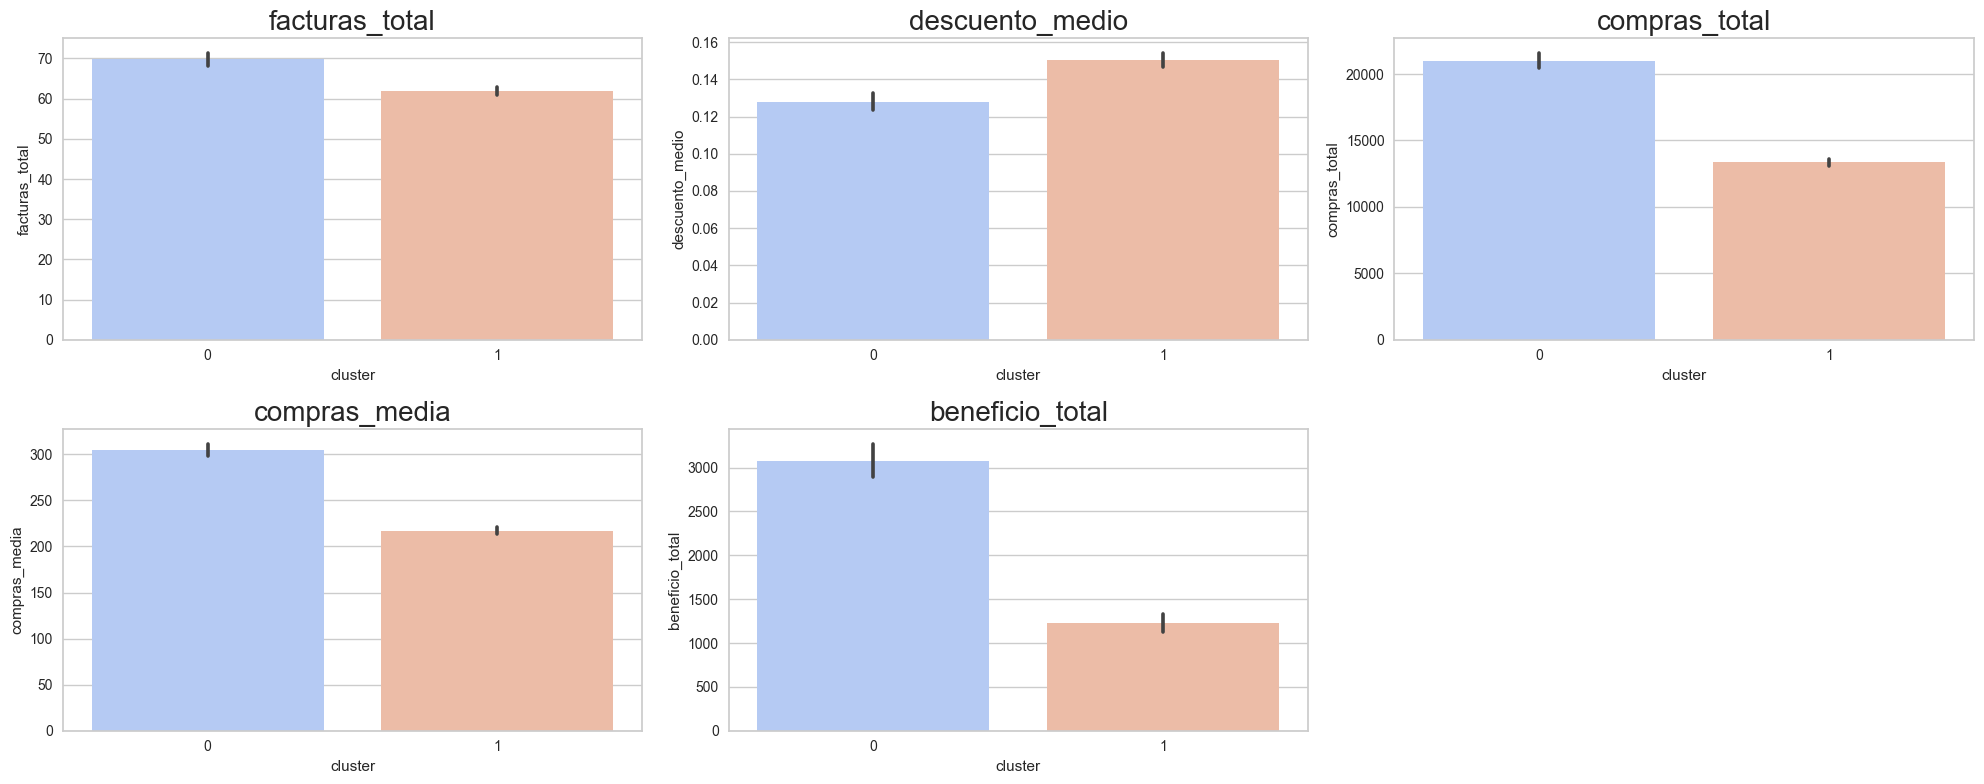

In [400]:
fig,axes = plt.subplots(nrows=2, ncols=math.ceil(len(lista_col_num) /2), figsize= (20,8))
axes = axes.flat

for indice, columna in enumerate(lista_col_num):
    df_group = df_clean.groupby('cluster')[columna].mean().reset_index()
    sns.barplot(x='cluster', y=columna, data=df_clean, ax=axes[indice], palette='coolwarm')
    axes[indice].set_title(columna, fontsize=20)

plt.tight_layout()
fig.delaxes(axes[-1])

## Observaciones:
    - El Cluster_0 tiene una media de facturas por encima del otro grupo, llegando hasta las 70 facturas mientras que Cluster_1 apenas supera las 60
    - El descuento medio mayor lo recibe el Cluster_1 ubicado en un 15%. Ligeramente por encima del Cluster_0
    - Para el total de compras, tenemos una media mucho mayor para el Cluster_0 ubicándose por encima de los 20000 mientras que el Cluster_1 no llega a ubicarse en los 15000. Hay una diferencia importante en cuanto a la media de ventas entre grupos.
    - En cuanto a la media de compras, seguimos observando un dominio por parte del Cluster_0 que se eleva más allá de los 300 pero el Cluster_1 apenas supera los 200.
    - El beneficio total generado por los grupos: el Cluster_0 tiene como beneficio total más de 3000 mientras que el Cluster_1 apenas supera los 1000.

* Cabe destacar que el Cluster_0 tiene cerca del 70% de los datos por lo que es normal que se vean cierta dominio en estas métricas

### Visualización de los clusters ya estandarizados

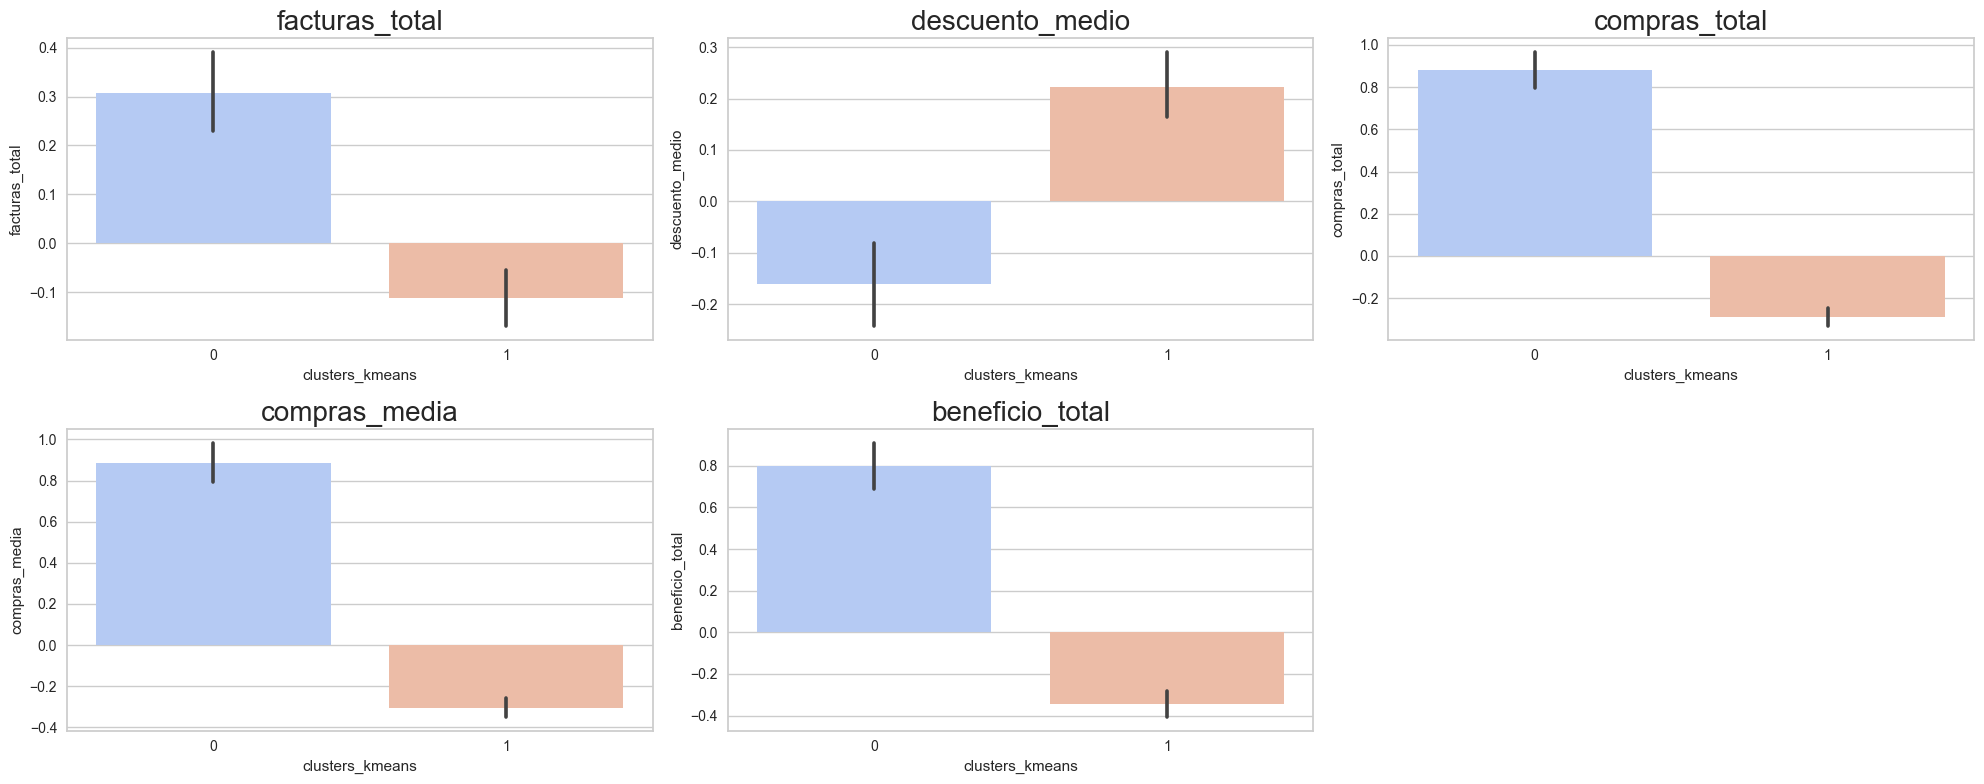

In [402]:
fig,axes = plt.subplots(nrows=2, ncols=math.ceil(len(lista_col_num) /2), figsize= (20,8))
axes = axes.flat

for indice, columna in enumerate(lista_col_num):
    df_group = df_modelo.groupby('clusters_kmeans')[columna].mean().reset_index()
    sns.barplot(x='clusters_kmeans', y=columna, data=df_modelo, ax=axes[indice], palette='coolwarm')
    axes[indice].set_title(columna, fontsize=20)

plt.tight_layout()
fig.delaxes(axes[-1])

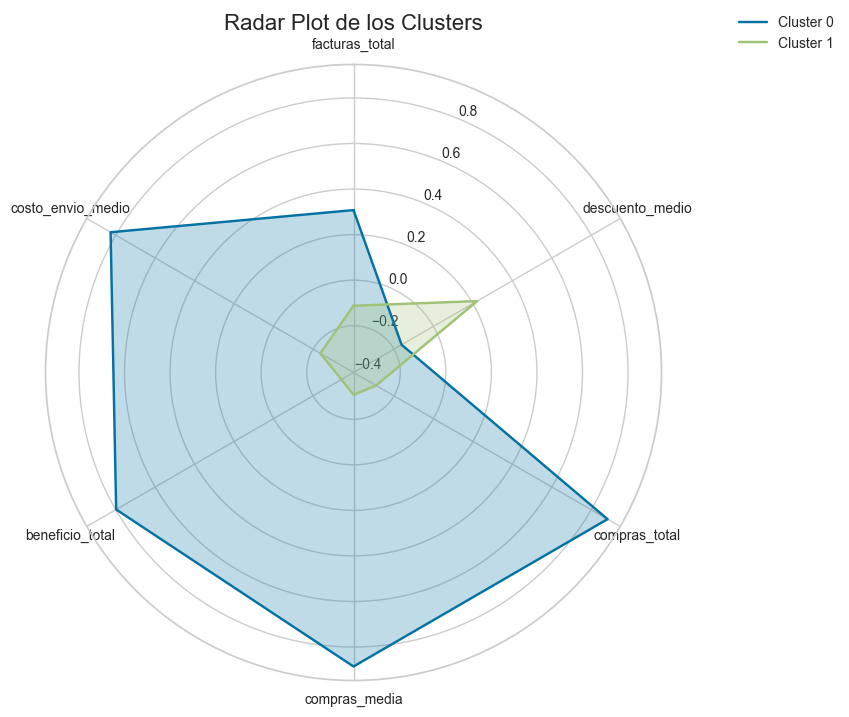

In [403]:
# Supongamos que 'df' es tu DataFrame
# Variables que deseas incluir en el radar plot

# Agrupar por cluster y calcular la media
cluster_means = df_modelo.groupby('clusters_kmeans')[lista_col_num].mean()

# Repetir la primera columna al final para cerrar el radar
cluster_means = pd.concat([cluster_means, cluster_means.iloc[:, 0:1]], axis=1)

# Crear los ángulos para el radar plot
num_vars = len(lista_col_num)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el gráfico

# Crear el radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Dibujar un gráfico para cada cluster
for i, row in cluster_means.iterrows():
    ax.plot(angles, row, label=f'Cluster {i}')
    ax.fill(angles, row, alpha=0.25)

# Configurar etiquetas de los ejes
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(lista_col_num)

# Añadir leyenda y título
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Radar Plot de los Clusters', size=16)
plt.show()

Aquí podemos ver claramente, con nuestros datos estandarizados la distribución de nuestros grupos y cómo el Cluster_0 tiene maayor predominancia y diferenciación sobre el Cluster_1

In [390]:
df_clean['cluster'] = df_clean['cluster'].astype(int)

### Conociendo mis clusters

In [394]:
df_clean[df_clean['cluster'] == 0].describe()

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio,cluster
count,264.00,264.00,264.00,264.00,264.00,264.00,264.00
mean,69.84,0.13,"21,019.43",304.35,"3,080.87",32.95,0.00
std,13.38,0.04,"4,580.51",56.95,"1,499.95",6.65,0.00
min,36.00,0.05,"10,920.80",213.06,"-1,896.98",19.09,0.00
25%,60.00,0.10,"17,953.87",268.94,"2,139.74",28.10,0.00
50%,69.00,0.13,"20,175.58",293.35,"2,873.73",32.18,0.00
75%,79.00,0.15,"23,382.79",327.63,"3,944.39",37.26,0.00
max,108.00,0.27,"40,488.07",703.42,"8,672.90",58.22,0.00


In [395]:
df_clean[df_clean['cluster'] == 1].describe()

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio,cluster
count,531.00,531.00,531.00,531.00,531.00,531.00,531.00
mean,61.87,0.15,"13,358.51",217.33,"1,231.84",23.07,1.00
std,12.66,0.05,"3,274.83",39.86,"1,148.50",5.34,0.00
min,29.00,0.05,"3,892.23",108.12,"-6,151.56",9.22,1.00
25%,53.00,0.12,"11,197.29",194.68,657.01,19.33,1.00
50%,62.00,0.14,"13,277.81",217.53,"1,380.71",22.91,1.00
75%,70.00,0.18,"15,537.33",242.16,"1,969.01",26.32,1.00
max,101.00,0.30,"24,216.45",421.36,"3,647.22",41.55,1.00


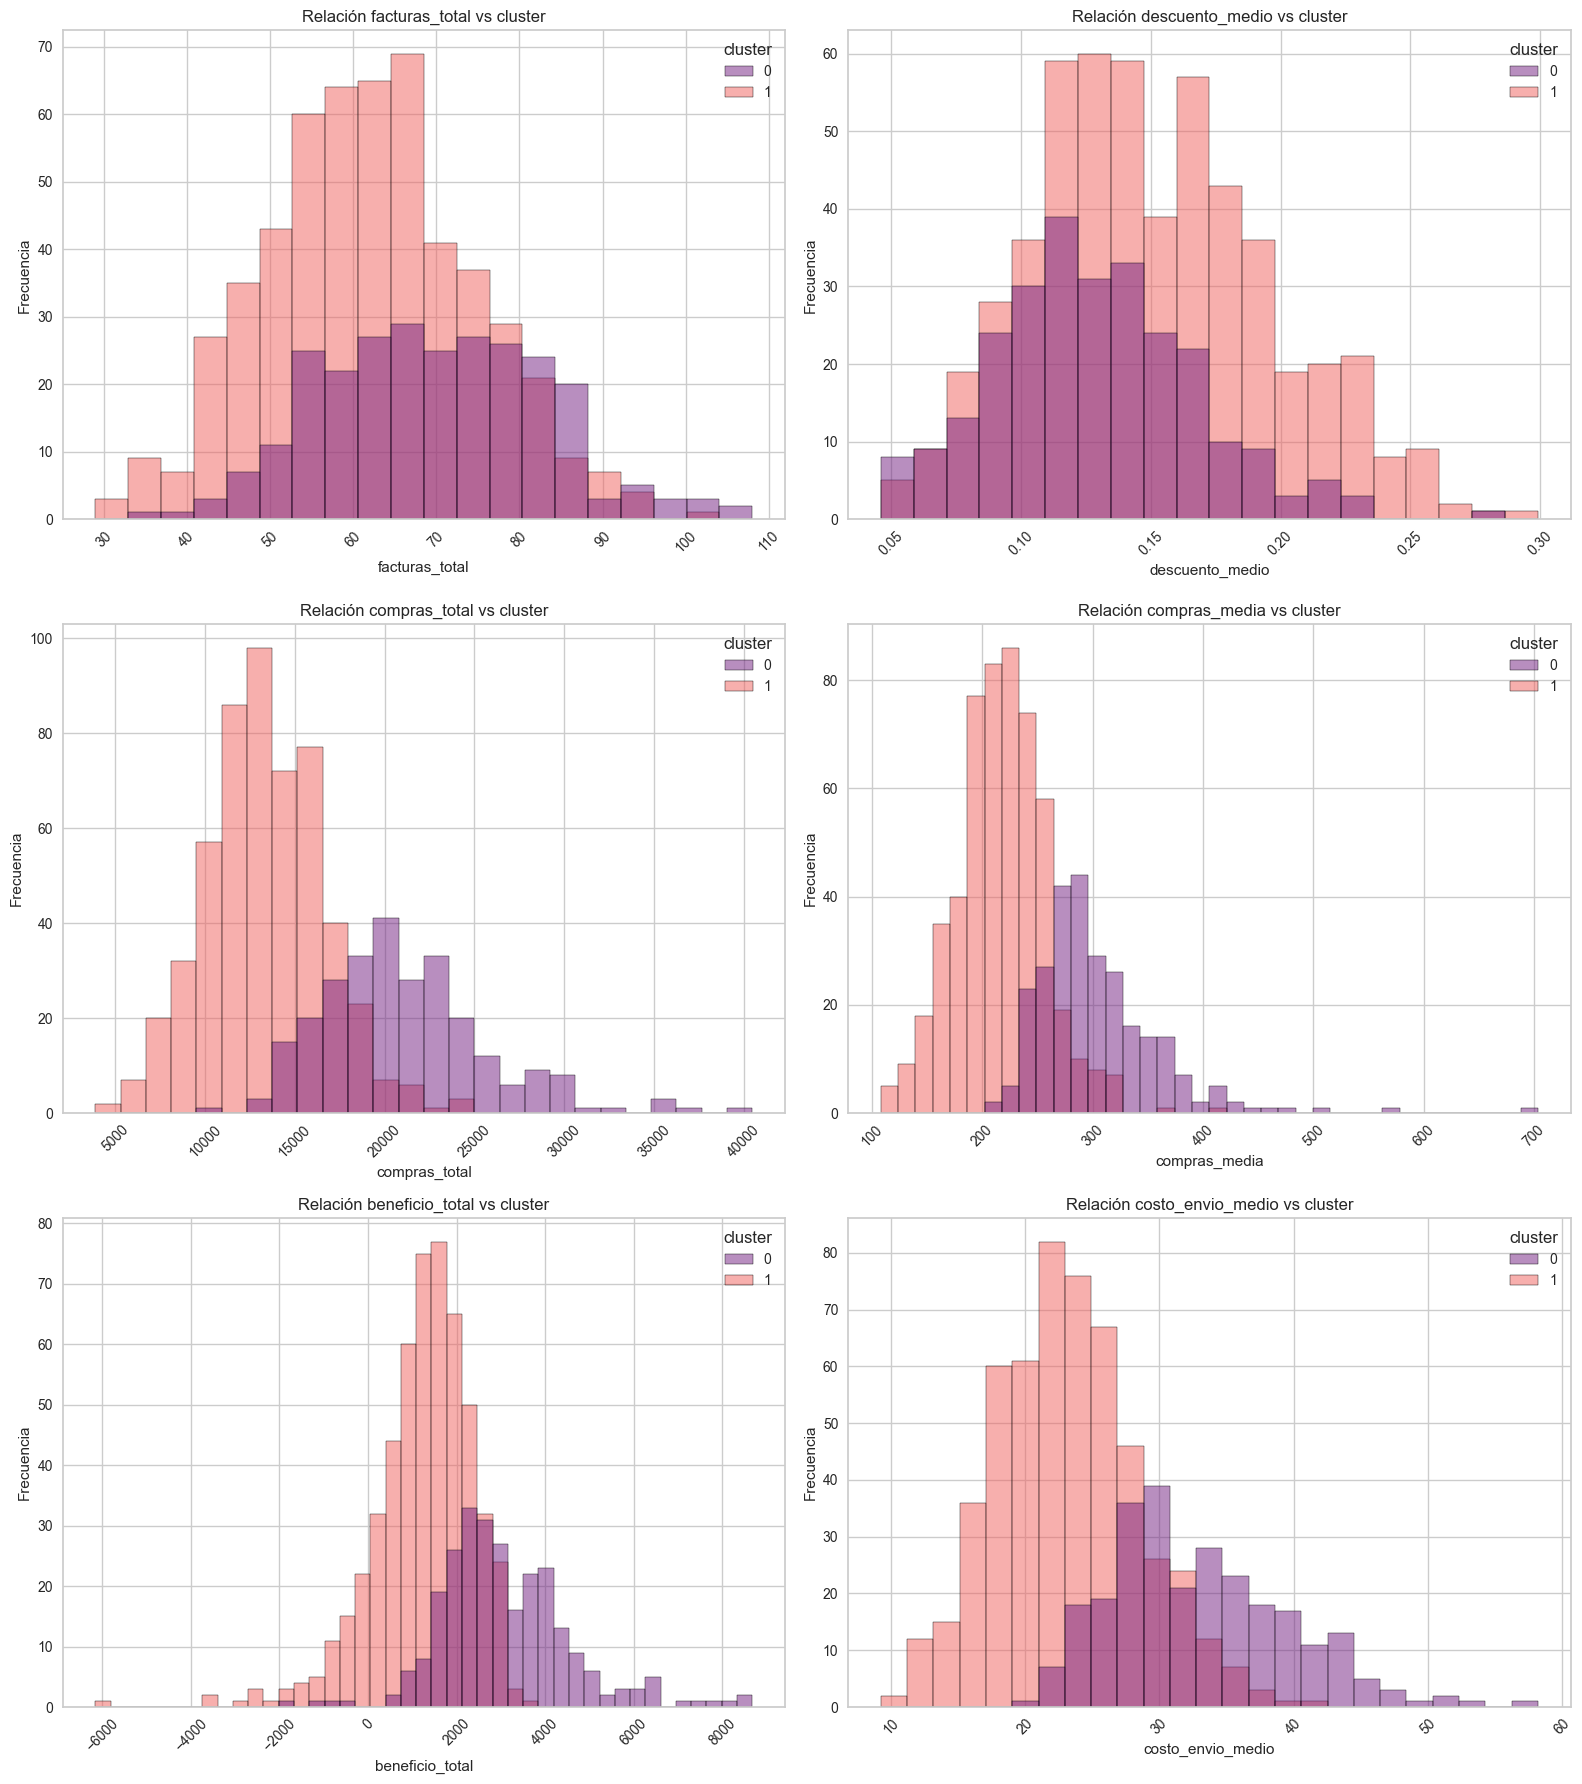

In [434]:
f.graficar_relaciones_numericas(df_clean, 'cluster')

## Clusters, K_Means

Para este método, tengo una distribución de 2 clusters. El Cluster_0 sería un grupo de clientes que, a pesar de ser una menor cantidad, hacen más facturas, no han utilizado tanto los descuentos, han gastado más en sus compras, tienen una media de compra mayor y aún más beneficio. Además, tienen un mayor costo de envío medio. Podríamos decir que hace referencia a personas que no escatiman para sus compras.

Para el Cluster_1 vemos una cantidad de más del doble de clientes. sin embargo, vemos una menor cantidad de pedidos en todos los parámetros, a excepción del descuento medio donde se elevan a un 30% de descuento.

In [404]:
lista_col_num

['facturas_total',
 'descuento_medio',
 'compras_total',
 'compras_media',
 'beneficio_total',
 'costo_envio_medio']

## Métodos aglomerativos

In [405]:
df_aglo = df_clean.copy()
df_aglo.drop(columns='cluster', inplace=True)

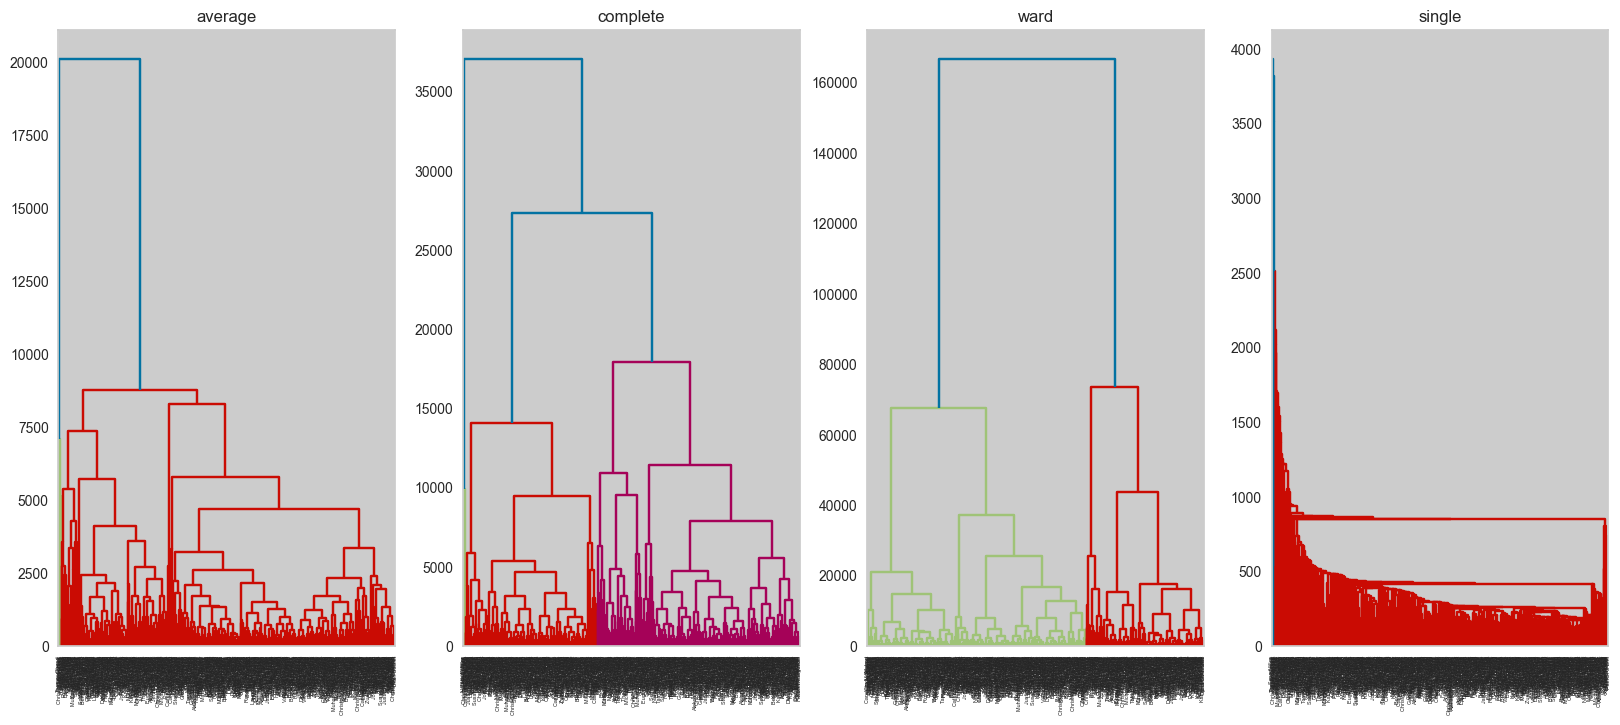

In [406]:
lista_metodos = ['average', 'complete', 'ward', 'single']

fig, axes = plt.subplots(nrows=1, ncols=len(lista_metodos), figsize=(20,8))
axes = axes.flat

for indice, metodo in enumerate(lista_metodos):
    sch.dendrogram(sch.linkage(df_aglo, method=metodo),
                   labels=df_aglo.index,
                   leaf_rotation=90,
                   leaf_font_size=4,
                   ax=axes[indice])
    axes[indice].set_title(metodo)

Viendo mis gráficos, los distintos modelos me describen ciertas cosas:
- Average: 2 clusters, uno ocupa casi todos los clientes mientras que el otro se queda con una mínima cantidad. Aquí se ven uniones a un nivel muy bajo, luego se van haciendo nuevas uniones un poco más altas.
- Complete: 3 clusters. Existe una diferencia clara entre colores, por lo que podemos ver dos grupos predominantes, aunque se encuentra un tercer cluster muy distanciado de los otros dos con un mínimo de elementos. Se ven muchas combinaciones bajas, pero sí hay una cierta distancia clara entre los 2 grupos, y se diferencia aún más con el tercer grupo menor.
- Ward: Tiene 2 clusters claros. Uno tiene mayor presencia que el otro, sin embargo dentro de ambos podemos ver cómo agrupa a los clientes más cercanos y luego va agrupando los que aún se parecen pero no se asemejan tanto. Luego vemos por la altura que existe una diferencia clara entre ambos grupos, lo que puede ser una buena señal.
- Single: básicamente une a todos en un cluster y deja por ahí un cluster muy pequeño adicional donde se puede haber colado 1 o 2 clientes. No parece muy buena opción.

### Métricas para comparar - Aglomerativo

In [407]:
# Configuraciones de vinculación y métricas de distancia
linkage_methods = ['single', 'complete', 'average', 'ward']
distance_metrics = ['euclidean', 'cosine', 'chebyshev']

# Crear un DataFrame para almacenar los resultados
results = []

# Suponiendo que tienes un DataFrame llamado df_copia
# Aquí df_copia debería ser tu conjunto de datos
# Asegúrate de que esté preprocesado adecuadamente (normalizado si es necesario)

for linkage_method in linkage_methods:
    for metric in distance_metrics:
        for cluster in range(2,8):
            try:
                # Configurar el modelo de AgglomerativeClustering
                modelo = AgglomerativeClustering(
                    linkage=linkage_method,
                    metric=metric,  
                    distance_threshold=None,  # Para buscar n_clusters
                    n_clusters=cluster, # Cambia esto según tu análisis
                )
                
                # Ajustar el modelo
                labels = modelo.fit_predict(df_aglo)

                # Calcular métricas si hay más de un cluster
                if len(np.unique(labels)) > 1:
                    # Silhouette Score
                    silhouette_avg = silhouette_score(df_aglo, labels, metric=metric)

                    # Davies-Bouldin Index
                    db_score = davies_bouldin_score(df_aglo, labels)

                    
                    # Cardinalidad (tamaño de cada cluster)
                    cluster_cardinality = {cluster: sum(labels == cluster) for cluster in np.unique(labels)}
                else:
                    inertia = float('inf')
                    cluster_cardinality = {'Cluster único': len(df_aglo)}

                # Almacenar resultados
                results.append({
                    'linkage': linkage_method,
                    'metric': metric,
                    'silhouette_score': silhouette_avg,
                    'davies_bouldin_index': db_score,
                    'cluster_cardinality': cluster_cardinality,
                    'n_cluster': cluster
                })

            except Exception as e:
                print(f"Error con linkage={linkage_method}, metric={metric}: {e}")

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)

# Mostrar resultados ordenados por silhouette_score
results_df = results_df.sort_values(by='silhouette_score', ascending=False)

# Mostrar el DataFrame
results_df.head(40)

Error con linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error con linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error con linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error con linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error con linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error con linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error con linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error con linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error con linkage=ward, metric=chebyshev: chebyshev was provided as 

,linkage,metric,silhouette_score,davies_bouldin_index,cluster_cardinality,n_cluster
42,average,cosine,0.93,0.98,"{0: 793, 1: 2}",2
6,single,cosine,0.93,0.98,"{0: 2, 1: 793}",2
7,single,cosine,0.91,0.48,"{0: 793, 1: 1, 2: 1}",3
24,complete,cosine,0.88,1.27,"{0: 787, 1: 8}",2
8,single,cosine,0.87,0.59,"{0: 792, 1: 1, 2: 1, 3: 1}",4
43,average,cosine,0.76,1.89,"{0: 744, 1: 2, 2: 49}",3
48,average,chebyshev,0.69,0.35,"{0: 790, 1: 5}",2
25,complete,cosine,0.69,3.13,"{0: 8, 1: 506, 2: 281}",3
26,complete,cosine,0.67,2.70,"{0: 506, 1: 6, 2: 281, 3: 2}",4
36,average,euclidean,0.67,0.39,"{0: 788, 1: 7}",2


En la mayoría de los casos, se pueden ver buenas métricas pero la distribución de Cluster no hace mucho sentido. Vamos a explorar nuestros 2 Clusters con el linkage 'Ward' utilizando las métricas euclidianas. Este caso nos arroja 2 clusters distribuidos de la siguiente forma: 278 y 517. Este caso tiene unas métricas de silhouette 0.53 y davies de 0.68. No son las mejores métricas pero es un silhouette por encima de 0.5 por lo que sí existe cierta unión de los elementos dentro de los clusters y una diferencia entre ellos estos 2. Además de un davies que no es tan elevado, por lo que los puntos no se encuentran muy lejos entre ellos.

### Método Ward

In [408]:
# Crear un DataFrame para almacenar los resultados
results = []

# Suponiendo que tienes un DataFrame llamado df_copia
# Aquí df_copia debería ser tu conjunto de datos
# Asegúrate de que esté preprocesado adecuadamente (normalizado si es necesario)
metric = 'euclidean'
try:
    # Configurar el modelo de AgglomerativeClustering
    modelo= AgglomerativeClustering(
        linkage='ward',
        metric=metric,  # o affinity si da error
        distance_threshold=None,  # Para buscar n_clusters
        n_clusters=2, # Cambia esto según tu análisis
    )
    
    # Ajustar el modelo
    labels_datos1 = modelo.fit_predict(df_aglo)

    # Calcular métricas si hay más de un cluster
    if len(np.unique(labels_datos1)) > 1:
        # Silhouette Score
        silhouette_avg = silhouette_score(df_aglo, labels_datos1, metric=metric)

        # Davies-Bouldin Index
        db_score = davies_bouldin_score(df_aglo, labels_datos1)

        
        # Cardinalidad (tamaño de cada cluster)
        cluster_cardinality = {cluster: sum(labels_datos1 == cluster) for cluster in np.unique(labels_datos1)}
    else:
        cluster_cardinality = {'Cluster único': len(df_aglo)}

    # Almacenar resultados
    results.append({
        'linkage': 'ward',
        'metric': metric,
        'silhouette_score': silhouette_avg,
        'davies_bouldin_index': db_score,
        'cluster_cardinality': cluster_cardinality,
        'n_cluster': 2
    })

except Exception as e:
    print(f"Error con linkage={linkage_method}, metric={metric}: {e}") # ward solo funciona con euclidiana

# Crear DataFrame de resultados
results_mod1 = pd.DataFrame(results)

# Mostrar resultados ordenados por silhouette_score
results_mod1 = results_mod1.sort_values(by='silhouette_score', ascending=False)

# Mostrar el DataFrame
results_mod1.head(20)

,linkage,metric,silhouette_score,davies_bouldin_index,cluster_cardinality,n_cluster
0,ward,euclidean,0.53,0.68,"{0: 278, 1: 517}",2


In [412]:
labels_datos1

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,

In [419]:
df_ward = df_clean.copy()
df_ward.drop(columns='cluster', inplace=True)

In [420]:
df_ward.head()

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio
Customer Name,,,,,,
Aaron Bergman,89,0.11,"24,644.63",276.91,"4,683.21",35.15
Aaron Hawkins,56,0.16,"20,759.51",370.71,"2,450.93",40.88
Aaron Smayling,60,0.17,"14,212.63",236.88,369.16,22.88
Adam Bellavance,68,0.13,"20,186.78",296.86,"4,979.98",40.17
Adam Hart,84,0.09,"21,718.20",258.55,"1,902.03",28.17


In [421]:
df_ward['cluster_ward'] = labels_datos1

In [422]:
df_ward.head()

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio,cluster_ward
Customer Name,,,,,,,
Aaron Bergman,89,0.11,"24,644.63",276.91,"4,683.21",35.15,0
Aaron Hawkins,56,0.16,"20,759.51",370.71,"2,450.93",40.88,0
Aaron Smayling,60,0.17,"14,212.63",236.88,369.16,22.88,1
Adam Bellavance,68,0.13,"20,186.78",296.86,"4,979.98",40.17,0
Adam Hart,84,0.09,"21,718.20",258.55,"1,902.03",28.17,0


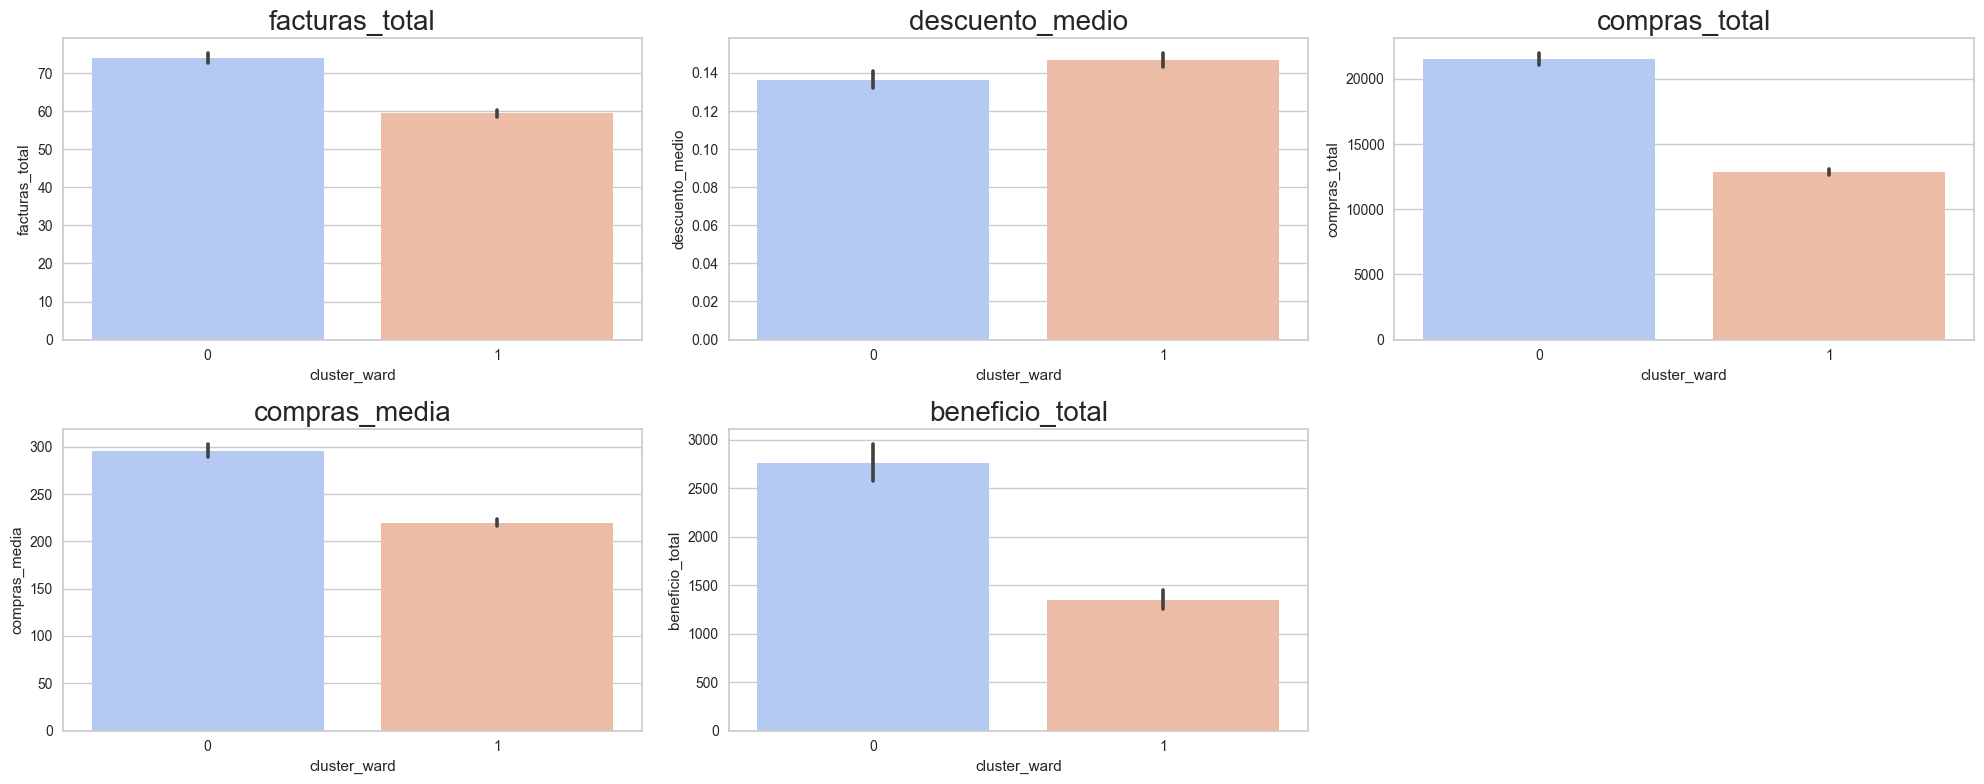

In [426]:
fig,axes = plt.subplots(nrows=2, ncols=math.ceil(len(lista_col_num) /2), figsize= (20,8))
axes = axes.flat

for indice, columna in enumerate(lista_col_num):
    df_group = df_ward.groupby('cluster_ward')[columna].mean().reset_index()
    sns.barplot(x='cluster_ward', y=columna, data=df_ward, ax=axes[indice], palette='coolwarm')
    axes[indice].set_title(columna, fontsize=20)

plt.tight_layout()
fig.delaxes(axes[-1])

Podemos visualizar, de medias, aún una dominancia por parte del Cluster_0 solo que se invierte el caso en 'descuento_medio'. Esto se asemeja bastante a nuestros clusters a través del K_Means.

In [425]:
df_ward[df_ward['cluster_ward'] == 0].describe()

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio,cluster_ward
count,278.00,278.00,278.00,278.00,278.00,278.00,278.00
mean,73.98,0.14,"21,525.07",295.92,"2,765.91",30.96,0.00
std,11.82,0.04,"3,947.56",61.37,"1,739.26",6.94,0.00
min,39.00,0.05,"16,339.75",188.18,"-3,577.92",18.09,0.00
25%,66.00,0.11,"18,589.76",252.65,"1,748.55",25.67,0.00
50%,74.00,0.13,"20,495.52",282.62,"2,619.20",29.99,0.00
75%,83.00,0.16,"23,337.74",324.35,"3,776.87",35.36,0.00
max,108.00,0.27,"40,488.07",703.42,"8,672.90",51.77,0.00


In [427]:
df_ward[df_ward['cluster_ward'] == 1].describe()

,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio,cluster_ward
count,517.00,517.00,517.00,517.00,517.00,517.00,517.00
mean,59.43,0.15,"12,879.18",219.51,"1,351.13",23.87,1.00
std,11.33,0.05,"2,685.08",42.48,"1,159.62",6.46,0.00
min,29.00,0.05,"3,892.23",108.12,"-6,151.56",9.22,1.00
25%,51.00,0.12,"11,080.34",194.54,771.98,19.19,1.00
50%,59.00,0.14,"13,092.74",218.51,"1,487.15",23.33,1.00
75%,67.00,0.18,"15,046.26",245.37,"2,090.96",27.35,1.00
max,96.00,0.30,"17,772.32",385.24,"4,105.60",58.22,1.00


In [ ]:
df_ward_0 = df_ward[df_ward['cluster_ward'] == 0]
df_ward_1 = df_ward[df_ward['cluster_ward'] == 1]

In [441]:
print(len(df_ward_0))
print(len(df_ward_1))

278
517


In [442]:
df_ward_0.to_csv('../Datos/df_cluster_0.csv')
df_ward_1.to_csv('../Datos/df_cluster_1.csv')

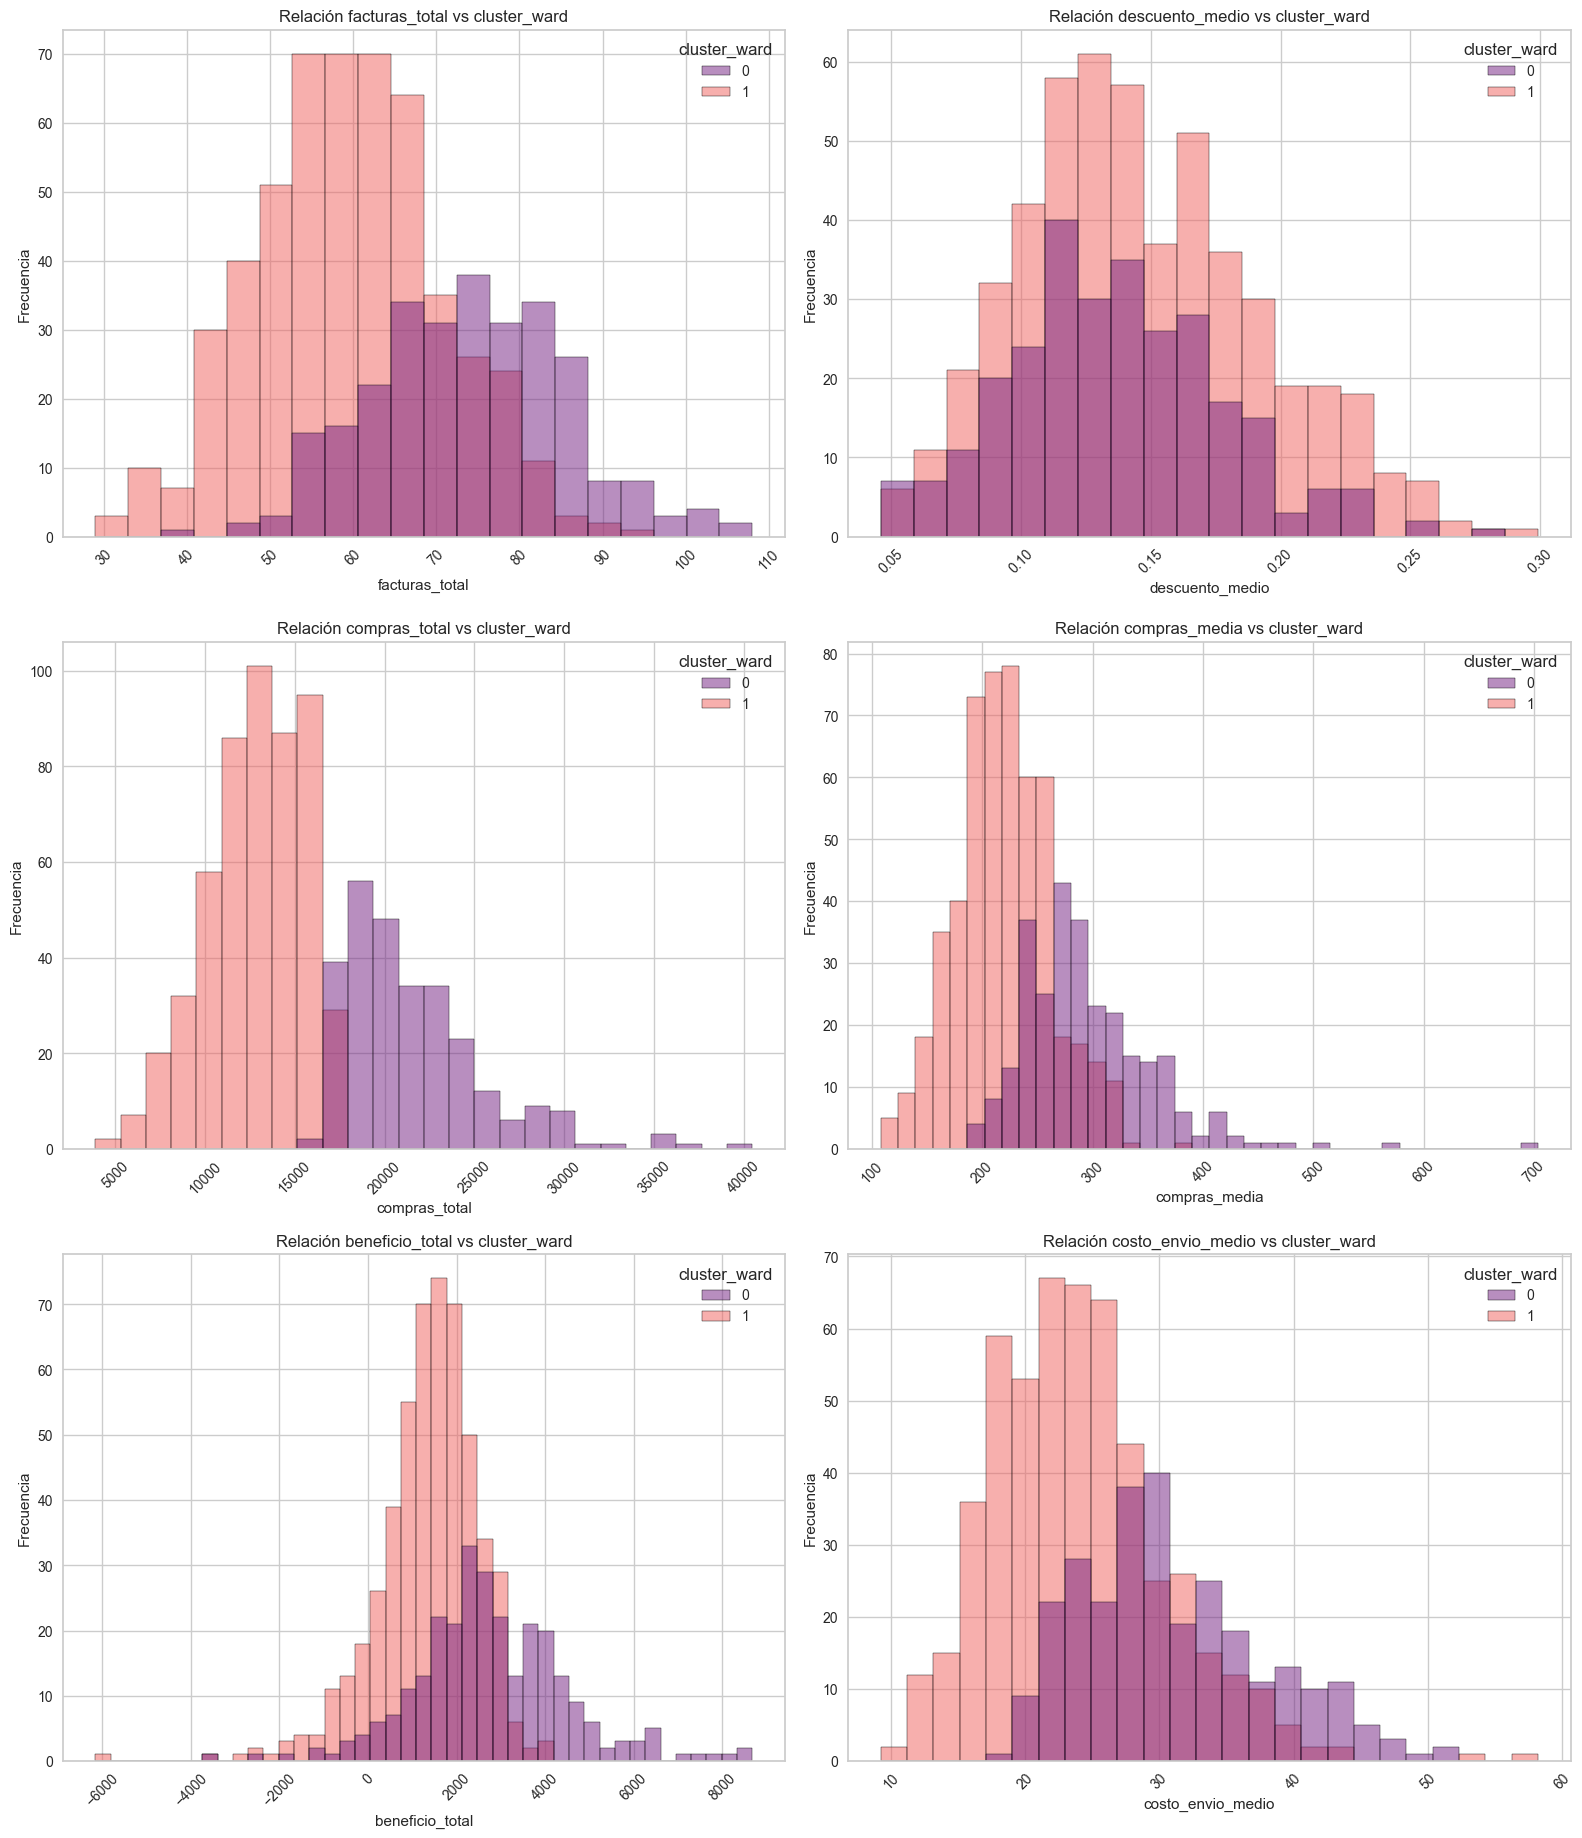

In [430]:
f.graficar_relaciones_numericas(df_ward, 'cluster_ward')

**Dentro de facturas totales**: 
    - Cluster_0 se queda con la distribución en las cantidades más elevadas, dejando a Cluster_1 con los menores valores.
**Dentro de descuento_medio**:
    - Cluster_1 al tener más clientes, gana en casos de descuento además de que tienes los mayores descuentos.
**Dentro de compras_total**:
    - Cluster_0 tiene una diferencia clara, por encima de Cluster_1 dejando claro que en Sales el Cluster_0 empieza donde el otro cluster termina.
**Dentro de compras_media**:
    - Cluster 0 se queda con las medias más altas.
**Dentro de beneficio_total**:
    - Cluster_0 deja más beneficios.


## DBScan

In [409]:
df_scan = df_clean.copy()
df_scan.drop(columns='cluster', inplace=True)

In [410]:
df_dbmeans = modelos.modelo_dbscan(df_scan)

eps: 0.5, min_samples: 3, silhouette: -0.34207388007434975
eps: 0.5, min_samples: 2, silhouette: -0.31955440095473836
eps: 0.5, min_samples: 1, silhouette: -0.11631580701877052
eps: 1.0, min_samples: 3, silhouette: 0.24510919243820475
eps: 1.0, min_samples: 2, silhouette: 0.10157118141570658
eps: 1.0, min_samples: 1, silhouette: -0.09555563078633231
eps: 1.5, min_samples: 3, silhouette: 0.48721525664893145
eps: 1.5, min_samples: 2, silhouette: 0.3930633442333097
eps: 1.5, min_samples: 1, silhouette: 0.1670700975174965


In [437]:
df_dbmeans['clusters_dbscan'].value_counts()

clusters_dbscan
 0    782
-1     13
Name: count, dtype: int64

El método db_scan no nos arroja una distribución muy lógica, al intentar hacerlo con más parámetros recibí todos negativos por lo que no es un buen método para mi modelo.

In [438]:
eps_values=[0.5,1,1.5, 2.5, 3,5, 10]
min_samples_values=[1,2,3,4,5,10, 15, 25]

metrics_results_dbscan = []

# Iterar sobre diferentes combinaciones de eps y min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels_db = dbscan.fit_predict(df_scan)
        print(labels_db)
        # Calcular la métrica de silueta, ignorando etiquetas -1 (ruido)
        if len(set(labels_db)) > 1 and len(set(labels_db)) < len(labels_db):
            silhouette = silhouette_score(df_scan, labels_db)
            davies_bouldin = davies_bouldin_score(df_scan, labels_db)
        else:
            silhouette = -1
            davies_bouldin = -1

        unique, counts = np.unique(labels_db, return_counts=True)
        cardinalidad = dict(zip(unique, counts))
        
        # Guardar resultados
        metrics_results_dbscan.append({
            "eps": eps,
            "min_samples": min_samples,
            "silhouette_score": silhouette,
            "davies_bouldin_score": davies_bouldin,
            "cardinality": cardinalidad
        })

    
# Mostrar las métricas en un DataFrame para análisis posterior
metrics_df_dbscan = pd.DataFrame(metrics_results_dbscan).sort_values(by = "silhouette_score", ascending=False)
metrics_df_dbscan

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
48,10.00,1,0.00,0.00,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ..."
49,10.00,2,-0.33,1.64,"{-1: 793, 0: 2}"
0,0.50,1,-1.00,-1.00,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ..."
41,5.00,2,-1.00,-1.00,{-1: 795}
30,2.50,15,-1.00,-1.00,{-1: 795}
31,2.50,25,-1.00,-1.00,{-1: 795}
32,3.00,1,-1.00,-1.00,"{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ..."
33,3.00,2,-1.00,-1.00,{-1: 795}
34,3.00,3,-1.00,-1.00,{-1: 795}
35,3.00,4,-1.00,-1.00,{-1: 795}
